In [1]:
#libraries
import re
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import pysal.model.spreg as spreg
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pysal.lib
import geopandas as gpd
import pandas as pd
from libpysal.weights import DistanceBand
from scipy.spatial import distance_matrix
import pandas as pd
from scipy.stats import pearsonr
from esda.moran import Moran
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import spreg
from spreg import SURlagIV
from spreg import GM_Lag
import libpysal
from spreg import AKtest
from spreg import ML_Lag
from spreg import GM_Combo

**Loading Path**

In [2]:
# Dependent variable
dep_var_path = r"C:\Users\soere\OneDrive\Desktop\Python MA\2.2 Saving the Dependent Variables"

# Independent variable
ind_var_path = r"C:\Users\soere\OneDrive\Desktop\Python MA\1.2 Saving the Independent Variables"

# Steamengines and horsepower
power_path = r"C:\Users\soere\OneDrive\Desktop\Python MA\0. Pretransformed Data"

In [3]:
# lets read the metadata
with pd.io.stata.StataReader(r"C:\Users\soere\OneDrive\Desktop\Python MA\0. Pretransformed Data\control.dta") as reader:
    meta_control = reader.variable_labels()
    
with pd.io.stata.StataReader(r"C:\Users\soere\OneDrive\Desktop\Python MA\0. Pretransformed Data\_FINAL_c_steamenginges_1904.dta") as reader:
    meta_steam = reader.variable_labels()

In [4]:
meta_control

{'id_inequality': 'County ID',
 'rb_id': 'District ID',
 'rb_name': 'District name',
 'province_id': 'Province ID',
 's_industry': 'Share industry employment',
 's_prot': 'Share Protestants',
 's_german': 'Share German-speaking',
 'longitud': 'Longitude',
 'latitud': 'Latitude',
 'slope_km': 'Terrain slope',
 'soil_suitability': 'Soil suitability',
 'mean_temp': 'Average temperature',
 'mean_preci': 'Average precipitation',
 'dist_100km': 'Distance to the nearest river',
 'log_distance_carbon_c': 'Least distance to carbon field (in log)'}

In [5]:
# Load Skill levels per Landkreis
skills_df = pd.read_csv(f"{dep_var_path}\Main_Dep.csv",
                        sep=",")

# Load control variables
control_df = pd.read_csv(f"{ind_var_path}\Independent Variables.csv",
                         sep=",")

# Load SteamEngine and Horsepower data
power_df = pd.read_stata(f"{power_path}\_FINAL_c_steamenginges_1904.dta")

In [6]:
# Merge the dataframes using an inner join on the "id_inequality" column
prep_df = pd.merge(control_df, skills_df, on="id_inequality", how="inner")
merged_df = pd.merge(prep_df, power_df, on="id_inequality", how="inner")

In [7]:
# Transform steamengines to steamengines per worker
merged_df["steamengines_number"] = (merged_df["steamengines_number"] / merged_df["d_Hauptberuf"])*1000
merged_df["horsepower"] = (merged_df["horsepower"] / merged_df["d_Hauptberuf"])*1000

merged_df["steamengines_number"] = np.log(merged_df["steamengines_number"])
merged_df["horsepower"] = np.log(merged_df["horsepower"])

In [8]:
# Drop Erblanden
#district_Erblanden = [31]
#merged_df = merged_df[~merged_df["rb_id"].isin(district_Erblanden)]

In [9]:
merged_df["per_unskilled"] = np.log(merged_df['per_unskilled'])
merged_df["per_low"] = np.log(merged_df['per_low'])
merged_df["per_medium"] = np.log(merged_df['per_medium'])
merged_df["per_high"] = np.log(merged_df['per_high'])

# Spatial Autocorrelation
First I check for spatial autocorrelation

In [10]:
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitud, merged_df.latitud))

In [11]:
# Compute the distance matrix
dist_matrix = distance_matrix(merged_df[["longitud", "latitud"]], merged_df[["longitud", "latitud"]])

# Compute the mean, median and 99th percentile distance
mean_distance = dist_matrix.mean()
median_distance = np.median(dist_matrix) 
percentile = np.percentile(dist_matrix, 99)

# Output
print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")
print(f"99th percentile: {percentile}")

Mean Distance: 5.704669124084842
Median Distance: 4.927124335311768
99th percentile: 15.027893188430875


In [12]:
# Creating spatial weights matrix (Euclidean distance)
w = DistanceBand.from_dataframe(gdf, threshold=median_distance, binary=False)

# Transform the matrix so all rows add up to 1
w.transform = "r"

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [13]:
# Check variables for spatial autocorrelation
mi_carbon = Moran(gdf["log_distance_carbon_c"], w)
mi_steam = Moran((gdf["steamengines_number"]), w)
mi_hp = Moran((gdf["horsepower"]), w)
mi_unskilled = Moran(gdf["per_unskilled"], w)
mi_low = Moran(gdf["per_low"], w)
mi_medium = Moran(gdf["per_medium"], w)
mi_high = Moran(gdf["per_high"], w)

# Output Moran's I value and p-value
print(f"log_distance_carbon_c - Moran's I: {mi_carbon.I}, p-value: {mi_carbon.p_sim}")
print(f"steamengines_number - Moran's I: {mi_steam.I}, p-value: {mi_steam.p_sim}")
print(f"horsepower - Moran's I: {mi_hp.I}, p-value: {mi_hp.p_sim}")
print(f"Unskilled - Moran's I: {mi_unskilled.I}, p-value: {mi_unskilled.p_sim}")
print(f"Low - Moran's I: {mi_low.I}, p-value: {mi_low.p_sim}")
print(f"Medium - Moran's I: {mi_medium.I}, p-value: {mi_medium.p_sim}")
print(f"High - Moran's I: {mi_high.I}, p-value: {mi_high.p_sim}")

log_distance_carbon_c - Moran's I: 0.3936368232919114, p-value: 0.001
steamengines_number - Moran's I: 0.09130664899311283, p-value: 0.001
horsepower - Moran's I: 0.17660521325922168, p-value: 0.001
Unskilled - Moran's I: 0.09185844426409279, p-value: 0.001
Low - Moran's I: 0.22295728806946738, p-value: 0.001
Medium - Moran's I: 0.11441762544703019, p-value: 0.001
High - Moran's I: 0.0984206523270208, p-value: 0.001


# 2SLS
Lets run a good'ol reliable IV first

## 2SLS function
I build a function that runs multiple 2SLS in a row, each time adding another variable from a list of control variables

In [14]:
def twoSLS(df, IV, first_stage_dependent, controls, second_stage_independent):
    """
    Performs a series of Two-Stage Least Squares (2SLS) regressions on a given DataFrame.
    In each iteration, an additional control variable from the provided list is included.

    Parameters:
    df (DataFrame): The DataFrame containing the data for regression.
    IV (str): The name of the instrumental variable column in the DataFrame.
    first_stage_dependent (str): The name of the dependent variable for the first stage regression.
    controls (list of str): A list of control variable names. Each iteration includes an additional control variable.
    second_stage_independent (str): The name of the main independent variable for the second stage regression.

    Returns:
    tuple of DataFrames: The first DataFrame contains the results (coefficients, significance, 
                         Adj. R-squared, F-statistic) of each first stage regression. 
                         The second DataFrame contains the results 
                         of each second stage regression. Significance is denoted by stars: 
                         *** for p < 0.01, ** for p < 0.05, and * for p < 0.1.
                         The third DataFrame contains the residuals.
    """

    first_stage_results = []
    second_stage_results = []
    # For analysis of spatial autocorrelation
    residuals = []

    for i in range(len(controls) + 1):
        # Subset of control variables for this iteration
        subset_controls = controls[:i]

        # Build the formula, handling the case with no controls
        controls_formula_part = " + ".join(subset_controls)
        if controls_formula_part:
            controls_formula_part = " + " + controls_formula_part

        # To avoid SettingWithCopyWarning
        df_copy = df.copy()

        # First Stage Regression
        first_stage_formula = f"{first_stage_dependent} ~ {IV}{controls_formula_part}"
        first_stage_model = smf.ols(first_stage_formula, data=df_copy)
        first_stage_fit = first_stage_model.fit()

        # Add the predicted values as a new column in the copy
        df_copy["predicted"] = first_stage_fit.predict(df_copy)

        # Second Stage Regression
        second_stage_formula = f"{second_stage_independent} ~ predicted{controls_formula_part}"
        second_stage_model = smf.ols(second_stage_formula, data=df_copy)
        second_stage_fit = second_stage_model.fit()

        def format_coef(coef, std_err, p_value):
            stars = ""
            if p_value < 0.01:
                stars = "***"
            elif p_value < 0.05:
                stars = "**"
            elif p_value < 0.1:
                stars = "*"
    
            # Check if coef or std_err is smaller than 0.000 and format accordingly
            coef_str = f"{coef:.10e}" if abs(coef) < 0.000 else f"{coef:.6f}"
            std_err_str = f"{std_err:.10e}" if abs(std_err) < 0.000 else f"{std_err:.6f}"

            return f"{coef_str}{stars} ({std_err_str})"


        # Extract coefficients and significance of first stage
        first_stage_summary = first_stage_fit.summary2().tables[1]
        first_stage_coefs = first_stage_summary.apply(lambda row: format_coef(row["Coef."], row["Std.Err."], row["P>|t|"]), axis=1)

        # Extract coefficients and significance of second stage
        second_stage_summary = second_stage_fit.summary2().tables[1]
        second_stage_coefs = second_stage_summary.apply(lambda row: format_coef(row["Coef."], row["Std.Err."], row["P>|t|"]), axis=1)

        # Adding R-squared and F-statistic
        first_stage_coefs.loc["Adj. R-squared"] = f"{first_stage_fit.rsquared_adj:.3f}"
        first_stage_coefs.loc["F-statistic"] = f"{first_stage_fit.fvalue:.3f}"
        second_stage_coefs.loc["Adj. R-squared"] = f"{second_stage_fit.rsquared_adj:.3f}"
        
        # Adding Standard Errors
        second_stage_se = second_stage_fit.bse["predicted"]
        second_stage_coefs.loc["std err"] = second_stage_se
        
        # Residuals
        res = second_stage_fit.resid
        
        # Append 
        first_stage_results.append(first_stage_coefs)
        second_stage_results.append(second_stage_coefs)
        residuals.append(res)

    # Convert the results to DataFrame
    first_stage_df = pd.DataFrame(first_stage_results).T
    second_stage_df = pd.DataFrame(second_stage_results).T
    
    # Df of residuals
    residuals_df = pd.DataFrame(residuals).T

    return first_stage_df, second_stage_df, residuals_df

## Use the Function

In [15]:
# DataFrame that contains all the variables for the regression analysis
dep_var = merged_df[["log_distance_carbon_c", 
                     "s_industry",
                     "s_prot", 
                     "s_german", 
                     "longitud", 
                     "latitud", 
                     "soil_suitability", 
                     "mean_temp", 
                     "mean_preci", 
                     "dist_100km",
                     "uni_dummy", 
                     "min_distance_uni", 
                     "prov_cap_dummy", 
                     "BER_dummy", 
                     "density",
                     "steamengines_number",
                     "per_low",
                     "per_medium",
                     "per_unskilled",
                     "per_high",
                     "d_Hauptberuf",
                     "horsepower"]]

In [16]:
# Make two lists of exogenous variables
# Exclude latitude and longitude once
control_list = ["longitud",
                "latitud",
                "soil_suitability", 
                "mean_temp", 
                "mean_preci", 
                "dist_100km",
                "s_prot", 
                "s_german",
                "density",
                "min_distance_uni", 
                "prov_cap_dummy", 
                "BER_dummy"]

control_list_2 = ["soil_suitability", 
                "mean_temp", 
                "mean_preci", 
                "dist_100km",
                "s_prot", 
                "s_german",
                "density",
                "min_distance_uni", 
                "prov_cap_dummy", 
                "BER_dummy"]

In [17]:
first_unskilled, second_unskilled, res_unskilled = twoSLS(dep_var,
                                                          "log_distance_carbon_c",
                                                          "steamengines_number",
                                                          control_list,
                                                          "per_unskilled")

first_low, second_low, res_low = twoSLS(dep_var,
                                        "log_distance_carbon_c",
                                        "steamengines_number",
                                        control_list,
                                        "per_low")

first_medium, second_medium, res_medium = twoSLS(dep_var,
                                                 "log_distance_carbon_c",
                                                 "steamengines_number",
                                                 control_list,
                                                 "per_medium")

first_high, second_high, res_high = twoSLS(dep_var,
                                           "log_distance_carbon_c",
                                           "steamengines_number",
                                           control_list,
                                           "per_high")

In [18]:
first_unskilled[[0,6,8,12]]

,0,6,8,12
Intercept,2.712226*** (0.060960),-9.296013*** (1.140911),-8.241082*** (1.265935),-4.686972*** (1.552541)
log_distance_carbon_c,-0.085319*** (0.015081),-0.189194*** (0.019696),-0.183569*** (0.020623),-0.181972*** (0.020230)
Adj. R-squared,0.051,0.255,0.259,0.314
F-statistic,32.006,29.136,23.333,21.247
longitud,NaN,0.041089*** (0.008771),0.039217*** (0.009695),0.037942*** (0.010037)
latitud,NaN,0.175338*** (0.021627),0.154514*** (0.025929),0.085070*** (0.030148)
soil_suitability,NaN,-0.130349*** (0.021163),-0.132144*** (0.021134),-0.112900*** (0.021196)
mean_temp,NaN,0.309222*** (0.039210),0.314864*** (0.040360),0.373902*** (0.039871)
mean_preci,NaN,0.006632*** (0.002537),0.007918*** (0.002678),0.010873*** (0.002687)
dist_100km,NaN,0.028245 (0.107598),0.019885 (0.108292),0.023486 (0.106203)


In [19]:
# First Stage (same for every regression)
second_unskilled[[0,6,8,12]]

,0,6,8,12
Intercept,0.723425*** (0.221062),-0.756821 (0.577926),-0.458010 (0.587330),-1.034525 (0.758904)
predicted,-0.607211*** (0.092234),-0.219641*** (0.057537),-0.156362** (0.061197),-0.149840** (0.058216)
Adj. R-squared,0.069,0.180,0.208,0.322
std err,0.092234,0.057537,0.061197,0.058216
longitud,NaN,-0.005044 (0.005495),-0.018562*** (0.006117),-0.014748** (0.006097)
latitud,NaN,0.029230*** (0.009329),0.036815*** (0.010362),0.042909*** (0.014002)
soil_suitability,NaN,-0.029577** (0.013886),-0.023677* (0.014034),-0.006525 (0.012674)
mean_temp,NaN,-0.076079*** (0.029215),-0.117291*** (0.031399),-0.103782*** (0.032304)
mean_preci,NaN,-0.003605** (0.001536),-0.005139*** (0.001671),-0.005755*** (0.001687)
dist_100km,NaN,0.121401** (0.059642),0.081475 (0.059147),0.023738 (0.055831)


In [20]:
second_low[[0,6,8,12]]

,0,6,8,12
Intercept,-4.535454*** (0.241738),1.698510*** (0.614747),0.955766 (0.627068),-0.020589 (0.852516)
predicted,1.261657*** (0.100861),0.286421*** (0.061203),0.259382*** (0.065338),0.251130*** (0.065398)
Adj. R-squared,0.213,0.344,0.362,0.396
std err,0.100861,0.061203,0.065338,0.065398
longitud,NaN,0.004159 (0.005845),0.014621** (0.006531),0.014144** (0.006849)
latitud,NaN,-0.093686*** (0.009924),-0.088864*** (0.011063),-0.067645*** (0.015729)
soil_suitability,NaN,0.054464*** (0.014771),0.053882*** (0.014983),0.039872*** (0.014238)
mean_temp,NaN,0.046824 (0.031077),0.067463** (0.033523),0.043329 (0.036289)
mean_preci,NaN,0.007427*** (0.001634),0.007574*** (0.001784),0.006903*** (0.001895)
dist_100km,NaN,-0.155250** (0.063442),-0.120600* (0.063149),-0.084786 (0.062718)


In [21]:
second_medium[[0,6,8,12]]

,0,6,8,12
Intercept,-1.720719*** (0.159496),-2.645249*** (0.415800),-2.595681*** (0.415087),-1.949072*** (0.550660)
predicted,0.139960** (0.066547),0.157603*** (0.041396),0.080015* (0.043250),0.074463* (0.042242)
Adj. R-squared,0.006,0.130,0.189,0.268
std err,0.066547,0.041396,0.04325,0.042242
longitud,NaN,-0.013227*** (0.003953),0.000178 (0.004323),-0.001897 (0.004424)
latitud,NaN,0.021065*** (0.006712),0.006311 (0.007323),-0.002986 (0.010160)
soil_suitability,NaN,-0.000818 (0.009991),-0.009364 (0.009918),-0.020493** (0.009197)
mean_temp,NaN,0.007467 (0.021019),0.055949** (0.022191),0.053659** (0.023440)
mean_preci,NaN,-0.001696 (0.001105),0.000531 (0.001181),0.001298 (0.001224)
dist_100km,NaN,-0.058834 (0.042911),-0.021774 (0.041801),0.017661 (0.040511)


In [22]:
second_high[[0,6,8,12]]

,0,6,8,12
Intercept,-6.590023*** (0.395599),-5.520670*** (1.047550),-6.097611*** (1.068709),-5.470768*** (1.417228)
predicted,0.717045*** (0.165056),0.478819*** (0.104293),0.379712*** (0.111354),0.362069*** (0.108717)
Adj. R-squared,0.030,0.124,0.147,0.231
std err,0.165056,0.104293,0.111354,0.108717
longitud,NaN,-0.021538** (0.009960),0.000464 (0.011130),-0.003284 (0.011386)
latitud,NaN,-0.004543 (0.016910),-0.014995 (0.018854),-0.019300 (0.026149)
soil_suitability,NaN,0.061147** (0.025170),0.052250** (0.025536),0.019348 (0.023669)
mean_temp,NaN,0.015670 (0.052955),0.080752 (0.057134),0.062612 (0.060327)
mean_preci,NaN,-0.003739 (0.002784),-0.001425 (0.003040),-0.000188 (0.003151)
dist_100km,NaN,-0.238483** (0.108107),-0.172836 (0.107624),-0.068928 (0.104263)


# Check error terms for spatial autocorrelation
Use the residuals

## Unskilled

In [23]:
test_statistics = []
p_values = []

for column in res_unskilled.columns:
    mi_res = Moran(res_unskilled[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.03919549948887549, P-value = 0.001
Variable 2: Test Statistic = 0.01589984521585869, P-value = 0.004
Variable 3: Test Statistic = 0.014368619374654293, P-value = 0.011
Variable 4: Test Statistic = 0.012937791317652034, P-value = 0.016
Variable 5: Test Statistic = 0.014187275443939018, P-value = 0.01
Variable 6: Test Statistic = 0.01584937119975952, P-value = 0.01
Variable 7: Test Statistic = 0.013535297022379338, P-value = 0.016
Variable 8: Test Statistic = 0.007689304794644507, P-value = 0.065
Variable 9: Test Statistic = 0.009944994497979651, P-value = 0.025
Variable 10: Test Statistic = 0.010389291492336857, P-value = 0.03
Variable 11: Test Statistic = 0.006188687420845653, P-value = 0.093
Variable 12: Test Statistic = 0.009854482151343456, P-value = 0.033
Variable 13: Test Statistic = 0.006161855842769654, P-value = 0.083


## Low

In [24]:
test_statistics = []
p_values = []

for column in res_low.columns:
    mi_res = Moran(res_unskilled[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.03919549948887549, P-value = 0.001
Variable 2: Test Statistic = 0.01589984521585869, P-value = 0.006
Variable 3: Test Statistic = 0.014368619374654293, P-value = 0.008
Variable 4: Test Statistic = 0.012937791317652034, P-value = 0.012
Variable 5: Test Statistic = 0.014187275443939018, P-value = 0.014
Variable 6: Test Statistic = 0.01584937119975952, P-value = 0.01
Variable 7: Test Statistic = 0.013535297022379338, P-value = 0.009
Variable 8: Test Statistic = 0.007689304794644507, P-value = 0.057
Variable 9: Test Statistic = 0.009944994497979651, P-value = 0.031
Variable 10: Test Statistic = 0.010389291492336857, P-value = 0.025
Variable 11: Test Statistic = 0.006188687420845653, P-value = 0.067
Variable 12: Test Statistic = 0.009854482151343456, P-value = 0.037
Variable 13: Test Statistic = 0.006161855842769654, P-value = 0.075


## Medium

In [25]:
test_statistics = []
p_values = []

for column in res_low.columns:
    mi_res = Moran(res_unskilled[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.03919549948887549, P-value = 0.001
Variable 2: Test Statistic = 0.01589984521585869, P-value = 0.004
Variable 3: Test Statistic = 0.014368619374654293, P-value = 0.011
Variable 4: Test Statistic = 0.012937791317652034, P-value = 0.01
Variable 5: Test Statistic = 0.014187275443939018, P-value = 0.01
Variable 6: Test Statistic = 0.01584937119975952, P-value = 0.011
Variable 7: Test Statistic = 0.013535297022379338, P-value = 0.016
Variable 8: Test Statistic = 0.007689304794644507, P-value = 0.061
Variable 9: Test Statistic = 0.009944994497979651, P-value = 0.039
Variable 10: Test Statistic = 0.010389291492336857, P-value = 0.033
Variable 11: Test Statistic = 0.006188687420845653, P-value = 0.067
Variable 12: Test Statistic = 0.009854482151343456, P-value = 0.024
Variable 13: Test Statistic = 0.006161855842769654, P-value = 0.078


## High

In [26]:
test_statistics = []
p_values = []

for column in res_low.columns:
    mi_res = Moran(res_unskilled[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.03919549948887549, P-value = 0.001
Variable 2: Test Statistic = 0.01589984521585869, P-value = 0.008
Variable 3: Test Statistic = 0.014368619374654293, P-value = 0.012
Variable 4: Test Statistic = 0.012937791317652034, P-value = 0.025
Variable 5: Test Statistic = 0.014187275443939018, P-value = 0.012
Variable 6: Test Statistic = 0.01584937119975952, P-value = 0.003
Variable 7: Test Statistic = 0.013535297022379338, P-value = 0.015
Variable 8: Test Statistic = 0.007689304794644507, P-value = 0.069
Variable 9: Test Statistic = 0.009944994497979651, P-value = 0.021
Variable 10: Test Statistic = 0.010389291492336857, P-value = 0.035
Variable 11: Test Statistic = 0.006188687420845653, P-value = 0.07
Variable 12: Test Statistic = 0.009854482151343456, P-value = 0.037
Variable 13: Test Statistic = 0.006161855842769654, P-value = 0.072


# Control for spatial autocorrelation

## IV with lag
In the second stage, lag controls on the dependent variable (i.e. skill share)

### Function

In [27]:
def IV_w_lag(df, IV, first_stage_dependent, dependent_var, controls, w):
    """
    Performs a series of IV regressions with spatial lag in the second-stage,
    incorporating a first-stage regression similar to twoSLS.

    Parameters:
    df (DataFrame): The DataFrame containing the data for regression.
    IV (str): The name of the instrumental variable column in the DataFrame.
    first_stage_dependent (str): The name of the dependent variable for the first stage regression.
    dependent_var (str): The name of the dependent variable for the regression.
    controls (list of str): A list of control variable names for both stages.
    w (libpysal.weights): weight matrix to control for spatial autocorrelation.

    Returns:
    Tuple of DataFrames
    First DataFrame containing the results of each second stage regression.
    Second DataFrame containing the residuals.
    Third DataFrame containing the pseudo-Rsquares.
    Fourth DataFrame containing the p-values from the AK test.
    """

    results = []
    res = []
    # Pseudo R-Squared
    pseudo_R = []
    # AKtest
    ak_pvalues = []

    for i in range(len(controls) + 1):
        subset_controls = controls[:i]

        # First Stage Regression
        df_copy = df.copy()
        controls_formula_part = " + ".join(subset_controls)
        first_stage_formula = f"{first_stage_dependent} ~ {IV}{(' + ' if controls_formula_part else '')}{controls_formula_part}"
        first_stage_model = smf.ols(first_stage_formula, data=df_copy)
        first_stage_fit = first_stage_model.fit()
        df_copy["predicted"] = first_stage_fit.predict(df_copy)

        # Second Stage Regression (Spatial Lag)
        X = df_copy[["predicted"] + subset_controls]
        y = df_copy[dependent_var]
        slm = spreg.ML_Lag(y.values, X.values, w, slx_lags = 0, name_y=dependent_var, name_x=["predicted"] + subset_controls)
        
        # Formatting results
        p_value = slm.output["prob"]
        coefs = slm.output["coefficients"]
        names = slm.output["var_names"]
        std = slm.output["std_err"]
        r = slm.pr2
        residuals = slm.e_pred
        
        # AKtest
        ak = AKtest(slm, w)
        ak_pvalues.append(ak.p)
        
        results.append(names)
        results.append(coefs)
        results.append(p_value)
        results.append(std)
        res.append(list(residuals))
        pseudo_R.append(r)

    # Convert the results to DataFrame
    results_df = pd.DataFrame(results).T
    residuals_df = pd.DataFrame(res).T
    residuals_df = residuals_df.astype(float)
    pseudoR_df = pd.DataFrame(pseudo_R)
    ak_pvalues_df = pd.DataFrame(ak_pvalues)

    return results_df, residuals_df, pseudoR_df, ak_pvalues_df

### Run the Function

In [28]:
lag_unskilled_second, res_lag_unskilled, R_un, ak_un = IV_w_lag(dep_var, "log_distance_carbon_c", "steamengines_number",
                                                          "per_unskilled", control_list, w)
lag_low_second, res_lag_low, R_low, ak_low = IV_w_lag(dep_var, "log_distance_carbon_c", "steamengines_number",
                                              "per_low", control_list, w)
lag_medium_second, res_lag_medium, R_medium, ak_medium = IV_w_lag(dep_var, "log_distance_carbon_c", "steamengines_number",
                                                       "per_medium", control_list, w)
lag_high_second, res_lag_high, R_high, ak_high = IV_w_lag(dep_var, "log_distance_carbon_c", "steamengines_number",
                                                 "per_high", control_list, w)

In [29]:
pd.set_option('display.max_columns', 40)

#### Unskilled

In [30]:
lag_unskilled_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,0.64423,0.002863,0.216035,CONSTANT,0.360176,0.143539,0.246234,CONSTANT,-1.042047,0.051596,0.535346,CONSTANT,-1.111038,0.038816,0.537738,CONSTANT,-0.7232,0.219859,0.589452,...,CONSTANT,-0.29067,0.652255,0.645029,CONSTANT,-0.737102,0.385221,0.848886,CONSTANT,-0.819035,0.331899,0.844109,CONSTANT,-1.072464,0.180678,0.801142,CONSTANT,-1.011111,0.206879,0.801074
1,predicted,-0.369995,0.00014,0.097172,predicted,-0.324067,0.000353,0.090704,predicted,-0.195229,0.000916,0.058889,predicted,-0.191638,0.000921,0.057833,predicted,-0.219134,0.000044,0.053641,...,predicted,-0.148646,0.016681,0.062099,predicted,-0.153928,0.009826,0.059618,predicted,-0.13622,0.025621,0.061033,predicted,-0.128539,0.024852,0.057289,predicted,-0.148482,0.011337,0.058639
2,W_per_unskilled,0.657876,0.000001,0.133684,longitud,0.006449,0.080489,0.00369,longitud,0.004417,0.247159,0.003817,longitud,0.003442,0.373325,0.003867,longitud,-0.000671,0.875581,0.004287,...,longitud,-0.020134,0.002112,0.00655,longitud,-0.018687,0.004054,0.006502,longitud,-0.020898,0.001882,0.006723,longitud,-0.018109,0.00508,0.006463,longitud,-0.015018,0.023262,0.006619
3,NaN,NaN,NaN,NaN,W_per_unskilled,0.531724,0.003552,0.182382,latitud,0.02142,0.026417,0.009649,latitud,0.023875,0.015419,0.009856,latitud,0.026007,0.008649,0.009905,...,latitud,0.0352,0.000985,0.010683,latitud,0.043103,0.004123,0.015026,latitud,0.043669,0.003247,0.014837,latitud,0.047304,0.000708,0.013968,latitud,0.042757,0.002353,0.014057
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_unskilled,0.527582,0.004126,0.183932,soil_suitability,-0.026283,0.05437,0.013661,soil_suitability,-0.029847,0.025466,0.013359,...,soil_suitability,-0.021719,0.124216,0.014128,soil_suitability,-0.021299,0.133624,0.0142,soil_suitability,-0.021578,0.125818,0.014096,soil_suitability,-0.013241,0.313541,0.013138,soil_suitability,-0.006236,0.623571,0.012706
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_unskilled,0.518185,0.005339,0.186005,mean_temp,-0.060822,0.005149,0.021741,...,mean_temp,-0.11734,0.00018,0.03133,mean_temp,-0.118343,0.000183,0.031625,mean_temp,-0.133255,0.000037,0.032283,mean_temp,-0.117173,0.000149,0.030898,mean_temp,-0.103852,0.001186,0.032031
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_unskilled,0.315707,0.149998,0.219311,...,mean_preci,-0.005064,0.002548,0.001678,mean_preci,-0.005335,0.002621,0.001773,mean_preci,-0.005995,0.000787,0.001786,mean_preci,-0.005799,0.000547,0.001678,mean_preci,-0.005743,0.000609,0.001675
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,0.079291,0.176231,0.058627,dist_100km,0.080813,0.166384,0.058395,dist_100km,0.048371,0.413372,0.059135,dist_100km,0.020081,0.717298,0.055462,dist_100km,0.023479,0.670318,0.055153
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.000316,0.498564,0.000466,s_prot,-0.000265,0.564352,0.00046,s_prot,-0.000472,0.308015,0.000463,s_prot,-0.000505,0.245135,0.000435,s_prot,-0.00044,0.314142,0.000437
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,-0.00245,0.000088,0.000625,s_german,-0.00253,0.000052,0.000626,s_german,-0.002131,0.000783,0.000635,s_german,-0.001957,0.001011,0.000595,s_german,-0.001872,0.001531,0.000591


In [31]:
R_un

,0
0,0.110896
1,0.109663
2,0.110609
3,0.110617
4,0.169970
5,0.186115
6,0.191050
7,0.204191
8,0.220602
9,0.224656


In [32]:
ak_un

,0
0,0.551089
1,0.901857
2,0.778387
3,0.747073
4,0.430812
5,0.109389
6,0.164558
7,0.404319
8,0.280843
9,0.264617


#### Low

In [33]:
lag_low_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-1.951482,0.0,0.321255,CONSTANT,-1.690573,0.0,0.278282,CONSTANT,2.150689,0.00002,0.50376,CONSTANT,2.264429,0.000007,0.503662,CONSTANT,2.208377,0.000049,0.543839,...,CONSTANT,0.932571,0.131744,0.618719,CONSTANT,0.257804,0.767467,0.871873,CONSTANT,0.226168,0.795053,0.870697,CONSTANT,0.662272,0.432762,0.844225,CONSTANT,0.453867,0.591526,0.84578
1,predicted,0.686658,0.0,0.106514,predicted,0.614931,0.0,0.09527,predicted,0.263713,0.000018,0.061444,predicted,0.258286,0.000019,0.060318,predicted,0.264724,0.000003,0.056789,...,predicted,0.219857,0.000919,0.066335,predicted,0.210756,0.000925,0.063624,predicted,0.200334,0.002322,0.065778,predicted,0.194714,0.002292,0.06385,predicted,0.208512,0.00147,0.065557
2,W_per_low,0.803607,0.0,0.072272,longitud,-0.00355,0.315638,0.003538,longitud,0.001569,0.66482,0.003621,longitud,0.003075,0.408429,0.00372,longitud,0.002863,0.500867,0.004253,...,longitud,0.022412,0.001849,0.007198,longitud,0.024811,0.000379,0.006981,longitud,0.026378,0.000274,0.00725,longitud,0.02388,0.000843,0.007153,longitud,0.021985,0.002651,0.007315
3,NaN,NaN,NaN,NaN,W_per_low,0.833517,0.0,0.085303,latitud,-0.059569,0.0,0.010576,latitud,-0.064687,0.0,0.010939,latitud,-0.066478,0.0,0.011275,...,latitud,-0.074323,0.0,0.012618,latitud,-0.062242,0.000128,0.016252,latitud,-0.061944,0.000128,0.016173,latitud,-0.064587,0.000039,0.015706,latitud,-0.060046,0.000157,0.015885
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_low,0.807281,0.0,0.095853,soil_suitability,0.047962,0.000823,0.014338,soil_suitability,0.04916,0.000553,0.014234,...,soil_suitability,0.044599,0.003096,0.015077,soil_suitability,0.044911,0.003123,0.015196,soil_suitability,0.044059,0.003809,0.015226,soil_suitability,0.0376,0.010281,0.014652,soil_suitability,0.030184,0.033915,0.014231
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_low,0.785045,0.0,0.103063,mean_temp,0.007368,0.7498,0.023104,...,mean_temp,0.065732,0.047584,0.03318,mean_temp,0.064221,0.055569,0.033546,mean_temp,0.070064,0.042278,0.034501,mean_temp,0.057286,0.093898,0.034197,mean_temp,0.04524,0.204283,0.035637
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_low,0.738239,0.0,0.115671,...,mean_preci,0.006594,0.000293,0.001821,mean_preci,0.006169,0.001269,0.001914,mean_preci,0.006397,0.000968,0.001939,mean_preci,0.006174,0.001032,0.001881,mean_preci,0.006108,0.00121,0.001887
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,-0.113037,0.069769,0.062334,dist_100km,-0.110483,0.075896,0.062243,dist_100km,-0.096894,0.127543,0.063584,dist_100km,-0.07415,0.229346,0.061687,dist_100km,-0.076423,0.21469,0.061593
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.000635,0.204964,0.000501,s_prot,-0.000558,0.257796,0.000493,s_prot,-0.000485,0.332606,0.000501,s_prot,-0.000409,0.399782,0.000485,s_prot,-0.000495,0.311911,0.00049
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.003139,0.000002,0.000662,s_german,0.003019,0.000006,0.000664,s_german,0.002864,0.000025,0.00068,s_german,0.002709,0.000041,0.00066,s_german,0.002643,0.000059,0.000658


In [34]:
R_low

,0
0,0.307651
1,0.308910
2,0.310089
3,0.311713
4,0.328753
5,0.351801
6,0.357437
7,0.359577
8,0.377749
9,0.377835


In [35]:
ak_low

,0
0,0.178540
1,0.257794
2,0.186640
3,0.262223
4,0.111922
5,0.134803
6,0.214611
7,0.304116
8,0.499925
9,0.499293


#### Medium

In [36]:
lag_medium_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-0.222009,0.204594,0.175007,CONSTANT,-0.204934,0.241536,0.174984,CONSTANT,-1.085342,0.003205,0.368237,CONSTANT,-1.097235,0.002759,0.366557,CONSTANT,-1.519975,0.000065,0.380651,...,CONSTANT,-1.677482,0.000229,0.455321,CONSTANT,-1.229224,0.037849,0.591974,CONSTANT,-1.422542,0.018604,0.60447,CONSTANT,-1.165499,0.044827,0.580927,CONSTANT,-1.342432,0.021949,0.585896
1,predicted,0.029762,0.632567,0.062249,predicted,0.022158,0.715764,0.060852,predicted,0.096068,0.016453,0.04005,predicted,0.09753,0.012532,0.039062,predicted,0.105937,0.003483,0.036261,...,predicted,0.056353,0.181442,0.04217,predicted,0.063503,0.117366,0.040553,predicted,0.049251,0.237328,0.041679,predicted,0.048987,0.226256,0.040483,predicted,0.057761,0.16338,0.041441
2,W_per_medium,0.895493,0.0,0.059769,longitud,-0.00059,0.74389,0.001806,longitud,-0.002388,0.258746,0.002115,longitud,-0.002762,0.208425,0.002196,longitud,0.001431,0.569028,0.002513,...,longitud,0.010478,0.017318,0.004403,longitud,0.008382,0.059432,0.004447,longitud,0.009282,0.047632,0.004687,longitud,0.007597,0.100515,0.004626,longitud,0.005876,0.216095,0.00475
3,NaN,NaN,NaN,NaN,W_per_medium,0.889341,0.0,0.062787,latitud,0.012456,0.057625,0.006561,latitud,0.013324,0.045515,0.006662,latitud,0.01358,0.035688,0.006465,...,latitud,0.004497,0.530748,0.007174,latitud,-0.003998,0.69695,0.010267,latitud,-0.003666,0.718953,0.010188,latitud,-0.00606,0.538804,0.009859,latitud,-0.002967,0.765737,0.009956
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_medium,0.833584,0.0,0.086241,soil_suitability,-0.010325,0.264828,0.00926,soil_suitability,-0.010218,0.25812,0.009036,...,soil_suitability,-0.014519,0.132276,0.009646,soil_suitability,-0.014632,0.131,0.009689,soil_suitability,-0.015248,0.114722,0.009667,soil_suitability,-0.018187,0.050146,0.009285,soil_suitability,-0.022883,0.011018,0.009002
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_medium,0.839136,0.0,0.083289,mean_temp,0.037561,0.011385,0.014842,...,mean_temp,0.065911,0.002257,0.02158,mean_temp,0.066546,0.002254,0.021786,mean_temp,0.075467,0.000713,0.022297,mean_temp,0.068298,0.00196,0.022059,mean_temp,0.060199,0.008699,0.022944
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_medium,0.829539,0.0,0.088627,...,mean_preci,0.001376,0.231044,0.001149,mean_preci,0.001634,0.18127,0.001222,mean_preci,0.001919,0.119639,0.001233,mean_preci,0.001908,0.111551,0.001199,mean_preci,0.001785,0.137271,0.001201
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,-0.012338,0.7617,0.040686,dist_100km,-0.014512,0.720337,0.040535,dist_100km,0.008389,0.838421,0.041142,dist_100km,0.021166,0.595016,0.039818,dist_100km,0.019833,0.61706,0.039664
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,0.000625,0.054791,0.000325,s_prot,0.00059,0.067059,0.000322,s_prot,0.000793,0.01588,0.000329,s_prot,0.000797,0.012277,0.000318,s_prot,0.000784,0.014725,0.000321
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.001585,0.00025,0.000433,s_german,0.001669,0.000123,0.000435,s_german,0.001385,0.00172,0.000442,s_german,0.001302,0.002341,0.000428,s_german,0.001251,0.003273,0.000426


In [37]:
R_medium

,0
0,0.138487
1,0.137180
2,0.145544
3,0.155965
4,0.194128
5,0.195657
6,0.196599
7,0.215303
8,0.231681
9,0.234956


In [38]:
ak_medium

,0
0,0.755853
1,0.745747
2,0.682768
3,0.898741
4,0.959588
5,0.842453
6,0.880397
7,0.617778
8,0.699833
9,0.635840


#### High

In [39]:
lag_high_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-1.452989,0.008298,0.550437,CONSTANT,-1.339159,0.008464,0.50861,CONSTANT,-1.400264,0.124751,0.912145,CONSTANT,-1.327787,0.143681,0.908063,CONSTANT,-2.461574,0.010035,0.95609,...,CONSTANT,-2.798478,0.012782,1.12398,CONSTANT,-2.236084,0.134024,1.492293,CONSTANT,-2.632174,0.082703,1.516919,CONSTANT,-1.965252,0.178369,1.460291,CONSTANT,-2.541207,0.087693,1.488094
1,predicted,0.343844,0.030964,0.159368,predicted,0.321052,0.036636,0.153628,predicted,0.320293,0.001562,0.101262,predicted,0.315632,0.001493,0.099378,predicted,0.338298,0.000232,0.09189,...,predicted,0.298552,0.005631,0.107839,predicted,0.306927,0.003066,0.103656,predicted,0.266432,0.012326,0.106459,predicted,0.267205,0.009821,0.103485,predicted,0.293944,0.005583,0.106066
2,W_per_high,0.873137,0.0,0.067774,longitud,-0.001344,0.770871,0.004615,longitud,-0.001737,0.739255,0.00522,longitud,-0.00054,0.920024,0.005381,longitud,0.00968,0.118243,0.006196,...,longitud,0.023118,0.034013,0.010905,longitud,0.020857,0.054791,0.01086,longitud,0.026125,0.020831,0.011304,longitud,0.02037,0.069104,0.011206,longitud,0.016114,0.160806,0.01149
3,NaN,NaN,NaN,NaN,W_per_high,0.881884,0.0,0.066174,latitud,-0.000404,0.980373,0.016414,latitud,-0.002793,0.867258,0.016712,latitud,-0.002382,0.883679,0.01628,...,latitud,-0.006778,0.709567,0.0182,latitud,-0.017374,0.50788,0.02624,latitud,-0.01681,0.517211,0.025956,latitud,-0.023351,0.353497,0.025167,latitud,-0.014321,0.573227,0.025423
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_high,0.8636,0.0,0.074102,soil_suitability,0.026544,0.259736,0.023553,soil_suitability,0.027297,0.23367,0.02292,...,soil_suitability,0.028858,0.242594,0.024696,soil_suitability,0.028698,0.247458,0.024813,soil_suitability,0.026736,0.279203,0.024708,soil_suitability,0.018793,0.428856,0.023753,soil_suitability,0.004865,0.832794,0.023043
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_high,0.866618,0.0,0.072761,mean_temp,0.094114,0.012321,0.037603,...,mean_temp,0.100703,0.067853,0.05515,mean_temp,0.101799,0.067527,0.055684,mean_temp,0.126711,0.025949,0.056898,mean_temp,0.106165,0.059467,0.056329,mean_temp,0.082068,0.161471,0.058614
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_per_high,0.842267,0.0,0.083243,...,mean_preci,0.000119,0.967732,0.002934,mean_preci,0.000464,0.88186,0.003121,mean_preci,0.001386,0.659335,0.003143,mean_preci,0.001286,0.674083,0.003058,mean_preci,0.000977,0.749808,0.003064
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,-0.142297,0.170769,0.103886,dist_100km,-0.144786,0.161983,0.103535,dist_100km,-0.085753,0.413773,0.104926,dist_100km,-0.050447,0.61964,0.101635,dist_100km,-0.054925,0.58768,0.101301
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.000283,0.732425,0.000826,s_prot,-0.000341,0.675548,0.000815,s_prot,0.000035,0.965845,0.000824,s_prot,0.0001,0.900577,0.000798,s_prot,-0.0,0.999831,0.000805
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.004214,0.000133,0.001103,s_german,0.004319,0.000095,0.001107,s_german,0.003621,0.001275,0.001124,s_german,0.003378,0.001929,0.001089,s_german,0.003239,0.002807,0.001084


In [40]:
R_high

,0
0,0.129250
1,0.130829
2,0.136096
3,0.136813
4,0.181735
5,0.182410
6,0.186411
7,0.189725
8,0.205091
9,0.208388


In [41]:
ak_high

,0
0,0.051214
1,0.056295
2,0.131370
3,0.108758
4,0.044357
5,0.031069
6,0.058137
7,0.103601
8,0.034130
9,0.029145


### Check if there is still spatial autocorrelation

#### Unskilled

In [42]:
for col in res_lag_unskilled.columns:
    res_lag_unskilled[col] = res_lag_unskilled[col].astype(float)

test_statistics = []
p_values = []

# 

for column in res_lag_unskilled.columns:
    mi_res = Moran(res_lag_unskilled[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.023525944368332514, P-value = 0.002
Variable 2: Test Statistic = 0.01570086061962296, P-value = 0.005
Variable 3: Test Statistic = 0.01352041062046587, P-value = 0.009
Variable 4: Test Statistic = 0.012788649490262594, P-value = 0.008
Variable 5: Test Statistic = 0.01594681249011586, P-value = 0.007
Variable 6: Test Statistic = 0.01726520242270739, P-value = 0.006
Variable 7: Test Statistic = 0.014463427030790564, P-value = 0.009
Variable 8: Test Statistic = 0.007698549409531949, P-value = 0.06
Variable 9: Test Statistic = 0.009954817946376742, P-value = 0.032
Variable 10: Test Statistic = 0.010363870464527776, P-value = 0.029
Variable 11: Test Statistic = 0.006186152028412164, P-value = 0.079
Variable 12: Test Statistic = 0.009839267691469847, P-value = 0.035
Variable 13: Test Statistic = 0.006191332093156474, P-value = 0.082


#### Low

In [43]:
for col in res_lag_low.columns:
    res_lag_low[col] = res_lag_low[col].astype(float)

test_statistics = []
p_values = []

# 

for column in res_lag_low.columns:
    mi_res = Moran(res_lag_low[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.042761493000927325, P-value = 0.001
Variable 2: Test Statistic = 0.041250456969714695, P-value = 0.001
Variable 3: Test Statistic = 0.04565179018514577, P-value = 0.001
Variable 4: Test Statistic = 0.044613616454050924, P-value = 0.001
Variable 5: Test Statistic = 0.05565076675141374, P-value = 0.001
Variable 6: Test Statistic = 0.02013212382147748, P-value = 0.002
Variable 7: Test Statistic = 0.016925483560800456, P-value = 0.005
Variable 8: Test Statistic = 0.015990589303692918, P-value = 0.007
Variable 9: Test Statistic = 0.012608893041976658, P-value = 0.018
Variable 10: Test Statistic = 0.012828375520838091, P-value = 0.016
Variable 11: Test Statistic = 0.012777482087359715, P-value = 0.009
Variable 12: Test Statistic = 0.015534613693878707, P-value = 0.003
Variable 13: Test Statistic = 0.014039151330681537, P-value = 0.007


#### Medium

In [44]:
for col in res_lag_medium.columns:
    res_lag_medium[col] = res_lag_medium[col].astype(float)

test_statistics = []
p_values = []

# 

for column in res_lag_medium.columns:
    mi_res = Moran(res_lag_medium[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.09784655347025936, P-value = 0.001
Variable 2: Test Statistic = 0.08355863775405259, P-value = 0.001
Variable 3: Test Statistic = 0.05129761817905917, P-value = 0.001
Variable 4: Test Statistic = 0.06051469226184662, P-value = 0.001
Variable 5: Test Statistic = 0.05678376974900078, P-value = 0.001
Variable 6: Test Statistic = 0.06636821322021132, P-value = 0.001
Variable 7: Test Statistic = 0.06556133823482321, P-value = 0.001
Variable 8: Test Statistic = 0.029400753865249315, P-value = 0.001
Variable 9: Test Statistic = 0.04111979895466488, P-value = 0.001
Variable 10: Test Statistic = 0.03586226962859265, P-value = 0.001
Variable 11: Test Statistic = 0.030648511685155092, P-value = 0.001
Variable 12: Test Statistic = 0.03128883588113737, P-value = 0.001
Variable 13: Test Statistic = 0.02849627818238831, P-value = 0.001


#### High

In [45]:
for col in res_lag_high.columns:
    res_lag_high[col] = res_lag_high[col].astype(float)

test_statistics = []
p_values = []

# 

for column in res_lag_high.columns:
    mi_res = Moran(res_lag_high[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.052425936447987445, P-value = 0.001
Variable 2: Test Statistic = 0.058571235465201994, P-value = 0.001
Variable 3: Test Statistic = 0.0443148513614843, P-value = 0.001
Variable 4: Test Statistic = 0.04611881201005728, P-value = 0.001
Variable 5: Test Statistic = 0.053247981413093996, P-value = 0.001
Variable 6: Test Statistic = 0.05591976299591131, P-value = 0.001
Variable 7: Test Statistic = 0.05047584626087852, P-value = 0.001
Variable 8: Test Statistic = 0.0398354574857092, P-value = 0.001
Variable 9: Test Statistic = 0.04526442560842671, P-value = 0.001
Variable 10: Test Statistic = 0.043965503917444006, P-value = 0.001
Variable 11: Test Statistic = 0.04076431247582079, P-value = 0.001
Variable 12: Test Statistic = 0.03956634547087259, P-value = 0.001
Variable 13: Test Statistic = 0.03454530363950125, P-value = 0.001


## IV with Error

### Function

ML_Error has no pseudo-Rsquared

In [46]:
def IV_w_error(df, IV, first_stage_dependent, dependent_var, controls, w):
    """
    Performs a series of IV regressions with spatial error in the second stage,
    incorporating a first-stage regression similar to twoSLS.

    Parameters:
    df (DataFrame): The DataFrame containing the data for regression.
    IV (str): The name of the instrumental variable column in the DataFrame.
    first_stage_dependent (str): The name of the dependent variable for the first stage regression.
    dependent_var (str): The name of the dependent variable for the regression.
    controls (list of str): A list of control variable names for both stages.
    w (libpysal.weights): weight matrix to control for spatial autocorrelation.

    Returns:
    Tuple of DataFrames
    First DataFrame containing the results of each second stage regression.
    Second DataFrame containing the residuals.
    Third DataFrame containing the pseudo-Rsquares.
    Fourth DataFrame containing the p-values from the AK test.
    """

    results = []
    res = []
    # Pseudo R-Squared
    pseudo_R = []
    # AKtest
    ak_pvalues = []

    for i in range(len(controls) + 1):
        subset_controls = controls[:i]

        # First Stage Regression
        df_copy = df.copy()
        controls_formula_part = " + ".join(subset_controls)
        first_stage_formula = f"{first_stage_dependent} ~ {IV}{(' + ' if controls_formula_part else '')}{controls_formula_part}"
        first_stage_model = smf.ols(first_stage_formula, data=df_copy)
        first_stage_fit = first_stage_model.fit()
        df_copy["predicted"] = first_stage_fit.predict(df_copy)

        # Second Stage Regression (Spatial Error)
        X = df_copy[["predicted"] + subset_controls]
        y = df_copy[dependent_var]
        slm = spreg.ML_Error(y.values, X.values, w,
                             name_y=dependent_var, name_x=["predicted"] + subset_controls)

        # Formatting results
        p_value = slm.output["prob"]
        coefs = slm.output["coefficients"]
        names = slm.output["var_names"]
        std = slm.output["std_err"]
        r = slm.pr2
        residuals = slm.u
        
        # AKtest
        ak = AKtest(slm, w)
        ak_pvalues.append(ak.p)

        results.append(names)
        results.append(coefs)
        results.append(p_value)
        results.append(std)
        res.append(list(residuals))
        pseudo_R.append(r)

    # Convert the results to DataFrame
    results_df = pd.DataFrame(results).T
    residuals_df = pd.DataFrame(res).T
    residuals_df = residuals_df.astype(float)
    pseudoR_df = pd.DataFrame(pseudo_R)
    ak_pvalues_df = pd.DataFrame(ak_pvalues)

    return results_df, residuals_df, pseudoR_df, ak_pvalues_df

### Run the Function

The error is no problem, it just tells me that the optimizing algorithm defaults to a different stopping point

In [47]:
error_unskilled_second, e_res_un, e_r2_un, e_ak_un = IV_w_error(dep_var, "log_distance_carbon_c",
                                                             "steamengines_number", "per_unskilled",
                                                             control_list, w)
error_low_second, e_res_low, e_r2_low, e_ak_low = IV_w_error(dep_var, "log_distance_carbon_c",
                                                             "steamengines_number", "per_low",
                                                             control_list, w)
error_medium_second, e_res_medium, e_r2_medium, e_ak_medium = IV_w_error(dep_var, "log_distance_carbon_c",
                                                            "steamengines_number", "per_medium",
                                                            control_list, w)
error_high_second, e_res_high, e_r2_high, e_ak_high = IV_w_error(dep_var, "log_distance_carbon_c",
                                                      "steamengines_number", "per_high",
                                                      control_list, w)

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not 

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not 

#### Unskilled

In [48]:
e_ak_un

,0
0,9.754972e-24
1,2.030661e-03
2,3.635555e-03
3,4.445945e-03
4,1.571362e-03
5,4.821368e-05
6,7.987641e-04
7,1.124907e-01
8,3.346536e-02
9,3.193040e-02


In [49]:
error_unskilled_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,0.30199,0.294779,0.288242,CONSTANT,-0.009169,0.971489,0.256538,CONSTANT,-1.768544,0.003282,0.60154,CONSTANT,-1.823906,0.002348,0.599527,CONSTANT,-1.207274,0.050026,0.616037,...,CONSTANT,-0.230381,0.733228,0.675932,CONSTANT,-0.848498,0.363459,0.933653,CONSTANT,-0.769714,0.378706,0.874394,CONSTANT,-1.284668,0.133953,0.857192,CONSTANT,-1.085404,0.184323,0.817592
1,predicted,-0.420122,0.000461,0.119949,predicted,-0.36991,0.000292,0.102126,predicted,-0.2036,0.001373,0.06362,predicted,-0.200075,0.001337,0.062369,predicted,-0.221554,0.000111,0.057312,...,predicted,-0.149548,0.019744,0.064151,predicted,-0.155072,0.011798,0.061582,predicted,-0.130878,0.034731,0.061984,predicted,-0.128012,0.030694,0.059237,predicted,-0.142221,0.016909,0.05954
2,lambda,0.720942,0.0,0.13025,longitud,0.013989,0.004065,0.004869,longitud,0.01152,0.020846,0.004985,longitud,0.010467,0.0367,0.00501,longitud,0.000323,0.954075,0.005609,...,longitud,-0.021908,0.002446,0.007231,longitud,-0.019618,0.007348,0.007318,longitud,-0.022113,0.001213,0.006834,longitud,-0.017367,0.012078,0.00692,longitud,-0.015516,0.018495,0.006587
3,NaN,NaN,NaN,NaN,lambda,0.516147,0.00664,0.190152,latitud,0.026706,0.02478,0.011897,latitud,0.02899,0.01627,0.012065,latitud,0.033435,0.004591,0.011796,...,latitud,0.035958,0.002826,0.012042,latitud,0.046596,0.005889,0.01692,latitud,0.044344,0.005296,0.015903,latitud,0.050714,0.001063,0.015494,latitud,0.044883,0.002703,0.014963
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.500758,0.009828,0.193954,soil_suitability,-0.024962,0.087813,0.014623,soil_suitability,-0.029466,0.03692,0.014121,...,soil_suitability,-0.018533,0.208023,0.014721,soil_suitability,-0.018465,0.211716,0.014785,soil_suitability,-0.017367,0.229188,0.014443,soil_suitability,-0.010636,0.435494,0.013639,soil_suitability,-0.004249,0.742337,0.012923
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.494256,0.011481,0.195536,mean_temp,-0.077086,0.000993,0.023412,...,mean_temp,-0.13181,0.00006,0.032841,mean_temp,-0.133522,0.000057,0.033159,mean_temp,-0.141029,0.000021,0.033131,mean_temp,-0.127151,0.000078,0.032175,mean_temp,-0.111685,0.000684,0.032887
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.524073,0.005349,0.18816,...,mean_preci,-0.005651,0.001821,0.001812,mean_preci,-0.005782,0.00232,0.001898,mean_preci,-0.006175,0.000868,0.001854,mean_preci,-0.006031,0.00071,0.001781,mean_preci,-0.005843,0.000796,0.001742
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,0.070807,0.253251,0.061977,dist_100km,0.069719,0.258912,0.061755,dist_100km,0.044375,0.467585,0.061088,dist_100km,0.015771,0.785922,0.058066,dist_100km,0.019194,0.73594,0.056915
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.000185,0.709865,0.000498,s_prot,-0.000181,0.710975,0.000488,s_prot,-0.000414,0.389217,0.000481,s_prot,-0.000463,0.313552,0.000459,s_prot,-0.000411,0.363501,0.000453
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,-0.00267,0.000046,0.000655,s_german,-0.002739,0.000029,0.000655,s_german,-0.00229,0.000445,0.000652,s_german,-0.002148,0.000528,0.00062,s_german,-0.002024,0.000851,0.000607


In [50]:
e_r2_un

,0
0,0.070320
1,0.096822
2,0.097803
3,0.098079
4,0.164301
5,0.181014
6,0.187443
7,0.203404
8,0.219193
9,0.223293


#### Low

In [51]:
e_ak_low

,0
0,1.323935e-189
1,9.893029e-27
2,3.196912e-19
3,1.925915e-15
4,4.913152e-13
5,4.869394e-04
6,2.525155e-03
7,2.983244e-03
8,1.045765e-02
9,8.745545e-03


In [52]:
error_low_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-3.52243,0.0,0.342375,CONSTANT,-2.879256,0.0,0.328473,CONSTANT,2.548024,0.000847,0.763539,CONSTANT,2.678256,0.000363,0.751151,CONSTANT,2.682207,0.000428,0.761553,...,CONSTANT,0.8994,0.233972,0.755679,CONSTANT,0.16262,0.87623,1.044115,CONSTANT,0.120811,0.907896,1.044245,CONSTANT,0.627539,0.547743,1.043904,CONSTANT,0.432254,0.674698,1.029892
1,predicted,0.805239,0.0,0.134746,predicted,0.724798,0.0,0.118519,predicted,0.281505,0.000064,0.070424,predicted,0.27729,0.000056,0.068791,predicted,0.291461,0.000006,0.064279,...,predicted,0.243912,0.000446,0.069461,predicted,0.234225,0.000458,0.066846,predicted,0.222521,0.001315,0.069262,predicted,0.218629,0.001326,0.068102,predicted,0.230472,0.000915,0.069517
2,lambda,0.908857,0.0,0.053352,longitud,-0.032428,0.006758,0.011973,longitud,-0.02148,0.055325,0.011209,longitud,-0.018215,0.080444,0.01042,longitud,-0.012764,0.222292,0.010459,...,longitud,0.015329,0.069645,0.00845,longitud,0.017765,0.039462,0.008627,longitud,0.018746,0.033465,0.008816,longitud,0.013977,0.13156,0.009268,longitud,0.012737,0.15896,0.009042
3,NaN,NaN,NaN,NaN,lambda,0.857082,0.0,0.077499,latitud,-0.086286,0.0,0.014831,latitud,-0.091482,0.0,0.014871,latitud,-0.097485,0.0,0.0146,...,latitud,-0.088935,0.0,0.013501,latitud,-0.07598,0.000056,0.018855,latitud,-0.074948,0.00007,0.018851,latitud,-0.080893,0.000016,0.018749,latitud,-0.075719,0.000049,0.018651
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.835925,0.0,0.086607,soil_suitability,0.048029,0.002584,0.015939,soil_suitability,0.054094,0.000565,0.01569,...,soil_suitability,0.045729,0.004093,0.015929,soil_suitability,0.046203,0.003978,0.016043,soil_suitability,0.04437,0.006001,0.016148,soil_suitability,0.03912,0.012575,0.015676,soil_suitability,0.032345,0.031181,0.015011
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.812465,0.0,0.096272,mean_temp,0.024235,0.354805,0.026191,...,mean_temp,0.078801,0.026681,0.035558,mean_temp,0.077329,0.03171,0.036,mean_temp,0.081863,0.026567,0.036911,mean_temp,0.068374,0.063906,0.036902,mean_temp,0.056101,0.142002,0.038206
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.801937,0.0,0.100471,...,mean_preci,0.007582,0.000134,0.001986,mean_preci,0.0071,0.00063,0.002077,mean_preci,0.007293,0.000525,0.002103,mean_preci,0.007061,0.00067,0.002076,mean_preci,0.006898,0.000859,0.00207
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,-0.111496,0.096661,0.067115,dist_100km,-0.108297,0.106344,0.067063,dist_100km,-0.098149,0.149232,0.068053,dist_100km,-0.075367,0.257856,0.066609,dist_100km,-0.076576,0.247726,0.066249
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.000742,0.170055,0.000541,s_prot,-0.000651,0.221062,0.000532,s_prot,-0.000554,0.30611,0.000542,s_prot,-0.000477,0.369615,0.000532,s_prot,-0.000548,0.303693,0.000533
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.003261,0.000004,0.000708,s_german,0.003126,0.000011,0.00071,s_german,0.002985,0.000037,0.000724,s_german,0.002817,0.00007,0.000709,s_german,0.002766,0.000084,0.000703


In [53]:
e_r2_low

,0
0,0.214501
1,0.256450
2,0.269424
3,0.275012
4,0.299696
5,0.345260
6,0.351739
7,0.352996
8,0.371320
9,0.371118


#### Medium

In [54]:
e_ak_medium

,0
0,1.579654e-187
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,2.713905e-84
8,0.000000e+00
9,0.000000e+00


In [55]:
error_medium_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-1.573483,0.0,0.221304,CONSTANT,-1.826509,0.0,0.282341,CONSTANT,-2.70329,0.000001,0.542013,CONSTANT,-2.774115,0.0,0.535874,CONSTANT,-3.265671,0.0,0.585744,...,CONSTANT,-4.001368,0.0,0.676271,CONSTANT,-3.358931,0.000068,0.843048,CONSTANT,-2.727596,0.000205,0.734652,CONSTANT,-2.459427,0.000641,0.720426,CONSTANT,-2.44568,0.000446,0.696566
1,predicted,0.054627,0.534914,0.088034,predicted,0.049931,0.53126,0.079751,predicted,0.092902,0.046781,0.046725,predicted,0.092044,0.043,0.045483,predicted,0.108861,0.010159,0.042352,...,predicted,0.059901,0.205932,0.047359,predicted,0.064336,0.156539,0.045409,predicted,0.051256,0.264629,0.045948,predicted,0.04837,0.280414,0.044813,predicted,0.055865,0.218856,0.045434
2,lambda,0.900248,0.0,0.057576,longitud,0.014721,0.202797,0.011559,longitud,0.00664,0.51343,0.01016,longitud,0.003775,0.704493,0.009955,longitud,0.022106,0.065799,0.012015,...,longitud,0.03994,0.00319,0.013545,longitud,0.034562,0.009344,0.013297,longitud,0.011366,0.139506,0.007692,longitud,0.009482,0.22318,0.007784,longitud,0.005893,0.388283,0.006831
3,NaN,NaN,NaN,NaN,lambda,0.947191,0.0,0.033202,latitud,0.017771,0.080455,0.010166,latitud,0.020666,0.043348,0.010229,latitud,0.014813,0.147199,0.01022,...,latitud,0.013154,0.211617,0.01053,latitud,0.003873,0.782188,0.014008,latitud,0.002672,0.838755,0.013131,latitud,-0.000439,0.972689,0.012821,latitud,0.001379,0.912439,0.012541
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.919339,0.0,0.048075,soil_suitability,-0.016027,0.12643,0.010487,soil_suitability,-0.010496,0.306842,0.010271,...,soil_suitability,-0.017048,0.114267,0.010794,soil_suitability,-0.016869,0.119739,0.010842,soil_suitability,-0.019241,0.072219,0.010703,soil_suitability,-0.021654,0.035591,0.010304,soil_suitability,-0.024932,0.010839,0.009785
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.915592,0.0,0.049979,mean_temp,0.055824,0.001212,0.017251,...,mean_temp,0.09161,0.000176,0.024422,mean_temp,0.091542,0.0002,0.024614,mean_temp,0.08823,0.00031,0.024464,mean_temp,0.079839,0.001001,0.024266,mean_temp,0.071202,0.004296,0.024935
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.955886,0.0,0.028249,...,mean_preci,0.002618,0.063152,0.001409,mean_preci,0.002528,0.081672,0.001452,mean_preci,0.002428,0.086165,0.001415,mean_preci,0.002265,0.10101,0.001381,mean_preci,0.002034,0.135874,0.001364
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,0.001148,0.980051,0.045928,dist_100km,0.00188,0.967212,0.045748,dist_100km,0.007235,0.87248,0.045077,dist_100km,0.020156,0.645275,0.043786,dist_100km,0.019326,0.655066,0.043261
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,0.000232,0.54009,0.000378,s_prot,0.000291,0.433059,0.000371,s_prot,0.000694,0.056155,0.000364,s_prot,0.000722,0.041034,0.000354,s_prot,0.000752,0.031903,0.00035
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.002301,0.000002,0.000481,s_german,0.002331,0.000001,0.00048,s_german,0.001901,0.00007,0.000478,s_german,0.001806,0.000102,0.000465,s_german,0.001731,0.00016,0.000458


In [56]:
e_r2_medium

,0
0,0.007660
1,0.046191
2,0.002005
3,0.002276
4,0.000177
5,0.000900
6,0.000337
7,0.120989
8,0.005233
9,0.013573


#### High

In [57]:
e_ak_high

,0
0,3.228791e-72
1,6.116525e-108
2,2.908937e-66
3,1.473441e-73
4,1.271370e-120
5,1.548452e-196
6,5.840635e-125
7,2.120943e-59
8,1.373264e-251
9,3.444027e-169


In [58]:
error_high_second

,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,...,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err,var_names,coefficients,prob,std_err
0,CONSTANT,-6.173076,0.0,0.554719,CONSTANT,-6.08881,0.0,0.593898,CONSTANT,-5.853096,0.000009,1.320786,CONSTANT,-5.866782,0.00001,1.329147,CONSTANT,-6.692112,0.000001,1.378371,...,CONSTANT,-8.412176,0.0,1.600248,CONSTANT,-7.390008,0.000351,2.067293,CONSTANT,-7.005367,0.000328,1.950242,CONSTANT,-6.18251,0.001128,1.898589,CONSTANT,-6.311589,0.000659,1.853027
1,predicted,0.505344,0.022498,0.221463,predicted,0.45341,0.02256,0.198794,predicted,0.352763,0.002709,0.117626,predicted,0.34605,0.002719,0.115433,predicted,0.39402,0.00022,0.10664,...,predicted,0.35622,0.003237,0.120985,predicted,0.360135,0.001889,0.115905,predicted,0.312378,0.008266,0.11828,predicted,0.305425,0.008078,0.115308,predicted,0.32531,0.005605,0.11744
2,lambda,0.896752,0.0,0.059265,longitud,0.002096,0.930541,0.024045,longitud,-0.003556,0.874169,0.022457,longitud,-0.002988,0.896905,0.023058,longitud,0.029068,0.268047,0.026245,...,longitud,0.061586,0.050345,0.031469,longitud,0.051204,0.093968,0.030572,longitud,0.029979,0.217214,0.024295,longitud,0.022321,0.341315,0.023457,longitud,0.01532,0.465498,0.020991
3,NaN,NaN,NaN,NaN,lambda,0.905203,0.0,0.055156,latitud,0.001751,0.944748,0.025269,latitud,0.001186,0.963228,0.025733,latitud,-0.0148,0.560033,0.025395,...,latitud,-0.002626,0.921561,0.026673,latitud,-0.017121,0.629916,0.035531,latitud,-0.013748,0.689914,0.034457,latitud,-0.022876,0.494455,0.033482,latitud,-0.01593,0.630278,0.033095
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.887272,0.0,0.063774,soil_suitability,0.019237,0.470303,0.026645,soil_suitability,0.034315,0.185171,0.025898,...,soil_suitability,0.030558,0.268037,0.02759,soil_suitability,0.031595,0.253866,0.02769,soil_suitability,0.023831,0.386732,0.027532,soil_suitability,0.017322,0.513274,0.026496,soil_suitability,0.006312,0.802557,0.025242
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.893083,0.0,0.061023,mean_temp,0.134668,0.001929,0.043428,...,mean_temp,0.158027,0.0112,0.062304,mean_temp,0.156907,0.012393,0.062744,mean_temp,0.164048,0.009224,0.063007,mean_temp,0.138992,0.026059,0.062459,mean_temp,0.11551,0.072957,0.064419
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lambda,0.923514,0.0,0.045929,...,mean_preci,0.002822,0.432127,0.003592,mean_preci,0.002202,0.551618,0.003699,mean_preci,0.002585,0.480483,0.003663,mean_preci,0.00206,0.564,0.00357,mean_preci,0.001532,0.66597,0.003549
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,dist_100km,-0.108689,0.353906,0.117243,dist_100km,-0.103671,0.37429,0.116685,dist_100km,-0.074891,0.518593,0.116018,dist_100km,-0.039885,0.723301,0.112655,dist_100km,-0.04218,0.705929,0.111785
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_prot,-0.001031,0.284648,0.000964,s_prot,-0.000811,0.390134,0.000944,s_prot,-0.000139,0.882608,0.000943,s_prot,-0.000018,0.9844,0.000915,s_prot,-0.000042,0.962865,0.000912
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,s_german,0.005427,0.00001,0.001229,s_german,0.005409,0.00001,0.001225,s_german,0.004647,0.000159,0.00123,s_german,0.004339,0.000284,0.001195,s_german,0.004216,0.000367,0.001183


In [59]:
e_r2_high

,0
0,0.031886
1,0.010349
2,0.047421
3,0.044275
4,0.051049
5,0.029629
6,0.051551
7,0.091618
8,0.041213
9,0.063845


### Check for spatial autocorrelation

#### Unskilled

In [60]:
e_ak_un

,0
0,9.754972e-24
1,2.030661e-03
2,3.635555e-03
3,4.445945e-03
4,1.571362e-03
5,4.821368e-05
6,7.987641e-04
7,1.124907e-01
8,3.346536e-02
9,3.193040e-02


In [61]:
test_statistics = []
p_values = []

# 

for column in e_res_un.columns:
    mi_res = Moran(e_res_un[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.05085000242761782, P-value = 0.001
Variable 2: Test Statistic = 0.01667382012383819, P-value = 0.007
Variable 3: Test Statistic = 0.01576779677713532, P-value = 0.007
Variable 4: Test Statistic = 0.015461700710430576, P-value = 0.008
Variable 5: Test Statistic = 0.01884638745941663, P-value = 0.001
Variable 6: Test Statistic = 0.024429594248808934, P-value = 0.001
Variable 7: Test Statistic = 0.020275128800541217, P-value = 0.004
Variable 8: Test Statistic = 0.009644826296188772, P-value = 0.034
Variable 9: Test Statistic = 0.01285580444203219, P-value = 0.013
Variable 10: Test Statistic = 0.012995227284354129, P-value = 0.017
Variable 11: Test Statistic = 0.007652463350053163, P-value = 0.056
Variable 12: Test Statistic = 0.011858360684597878, P-value = 0.019
Variable 13: Test Statistic = 0.007717054912117078, P-value = 0.067


#### Low

In [62]:
e_ak_low

,0
0,1.323935e-189
1,9.893029e-27
2,3.196912e-19
3,1.925915e-15
4,4.913152e-13
5,4.869394e-04
6,2.525155e-03
7,2.983244e-03
8,1.045765e-02
9,8.745545e-03


In [63]:
test_statistics = []
p_values = []

# 

for column in e_res_low.columns:
    mi_res = Moran(e_res_low[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.12470842390943207, P-value = 0.001
Variable 2: Test Statistic = 0.05295643561564489, P-value = 0.001
Variable 3: Test Statistic = 0.04652472052229853, P-value = 0.001
Variable 4: Test Statistic = 0.0424034440388765, P-value = 0.001
Variable 5: Test Statistic = 0.0438940956676033, P-value = 0.001
Variable 6: Test Statistic = 0.021439937648859927, P-value = 0.002
Variable 7: Test Statistic = 0.01856103646992875, P-value = 0.003
Variable 8: Test Statistic = 0.0182482581204122, P-value = 0.001
Variable 9: Test Statistic = 0.015738490643268887, P-value = 0.005
Variable 10: Test Statistic = 0.016116654516488006, P-value = 0.006
Variable 11: Test Statistic = 0.016800403309849693, P-value = 0.005
Variable 12: Test Statistic = 0.020530221500383222, P-value = 0.003
Variable 13: Test Statistic = 0.01899327100946723, P-value = 0.002


#### Medium

In [64]:
e_ak_medium

,0
0,1.579654e-187
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,2.713905e-84
8,0.000000e+00
9,0.000000e+00


In [65]:
test_statistics = []
p_values = []

# 

for column in e_res_medium.columns:
    mi_res = Moran(e_res_medium[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.11023208770317218, P-value = 0.001
Variable 2: Test Statistic = 0.28184948857440456, P-value = 0.001
Variable 3: Test Statistic = 0.19342050242331235, P-value = 0.001
Variable 4: Test Statistic = 0.1727054308679373, P-value = 0.001
Variable 5: Test Statistic = 0.32949443892097374, P-value = 0.001
Variable 6: Test Statistic = 0.39816919549833585, P-value = 0.001
Variable 7: Test Statistic = 0.382200506901132, P-value = 0.001
Variable 8: Test Statistic = 0.1038195184935753, P-value = 0.001
Variable 9: Test Statistic = 0.3863777425127988, P-value = 0.001
Variable 10: Test Statistic = 0.34661138152958526, P-value = 0.001
Variable 11: Test Statistic = 0.05532527648041693, P-value = 0.001
Variable 12: Test Statistic = 0.062404881064383334, P-value = 0.001
Variable 13: Test Statistic = 0.04406621711989354, P-value = 0.001


#### High

In [66]:
test_statistics = []
p_values = []

# 

for column in e_res_high.columns:
    mi_res = Moran(e_res_high[column], w)
    
    test_statistics.append(mi_res.I)
    p_values.append(mi_res.p_sim)

for i in range(len(test_statistics)):
    
    print(f"Variable {i+1}: Test Statistic = {test_statistics[i]}, P-value = {p_values[i]}")

Variable 1: Test Statistic = 0.08036271013732707, P-value = 0.001
Variable 2: Test Statistic = 0.09768440888768329, P-value = 0.001
Variable 3: Test Statistic = 0.0758390721137052, P-value = 0.001
Variable 4: Test Statistic = 0.0775951288068932, P-value = 0.001
Variable 5: Test Statistic = 0.1371181434941743, P-value = 0.001
Variable 6: Test Statistic = 0.17595148413322712, P-value = 0.001
Variable 7: Test Statistic = 0.14292484097327188, P-value = 0.001
Variable 8: Test Statistic = 0.09888772405357661, P-value = 0.001
Variable 9: Test Statistic = 0.1937715139365902, P-value = 0.001
Variable 10: Test Statistic = 0.1632241602264761, P-value = 0.001
Variable 11: Test Statistic = 0.062790147802574, P-value = 0.001
Variable 12: Test Statistic = 0.06340095127192728, P-value = 0.001
Variable 13: Test Statistic = 0.049888380811299655, P-value = 0.001


## Function GM_Lag
Makes little sense as we instrument our dependent variable --> against exclusion restriction

In [67]:
X = dep_var[control_list_2] 
yend = dep_var["steamengines_number"].astype(float).to_frame()
q = dep_var["log_distance_carbon_c"].to_frame()

### Unskilled

In [68]:
y_un = dep_var["per_unskilled"].to_frame()
reg_un=GM_Lag(y_un.values, X.values, yend.values, q.values,
              w=w, w_lags=1, robust="white", spat_diag = True, name_x=control_list_2)
reg_un.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,0.418929,0.152208,2.752349,0.005917
1,soil_suitability,-0.003885,0.017551,-0.221344,0.824825
2,mean_temp,-0.064203,0.026687,-2.405777,0.016138
3,mean_preci,-0.002715,0.001588,-1.709713,0.087319
4,dist_100km,0.03261,0.061308,0.531909,0.594789
5,s_prot,-0.000009,0.000348,-0.025946,0.979301
6,s_german,-0.001422,0.000469,-3.0315,0.002433
7,density,-0.001753,0.001479,-1.185398,0.23586
8,min_distance_uni,0.023583,0.031379,0.751561,0.452315
9,prov_cap_dummy,-0.685333,0.100919,-6.790911,0.0


In [69]:
print(reg_un.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -0.7297                Number of Variables   :          13
S.D. dependent var  :      0.3001                Degrees of Freedom    :         562
Pseudo R-squared    :      0.2871
Spatial Pseudo R-squared:  0.2877

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.41893         0.15221         2.75235         0.00592
    soil_suitability        -0.00388         0.01755        -0.22134         0.82482
           mean_temp

In [70]:
res_lag_un = reg_un.e_pred

mi_res_lag_un = Moran(res_lag_un, w)
    
print(f"P-value = {mi_res_lag_un.p_sim}")

P-value = 0.165


### Low

In [71]:
y = dep_var["per_low"].to_frame()
reg_low=GM_Lag(y.values, X.values, yend.values, q.values,
               w=w, w_lags=1, robust="white", spat_diag = True)
reg_low.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-1.538821,0.654403,-2.351487,0.018699
1,var_1,0.027723,0.015872,1.746681,0.080693
2,var_2,-0.027869,0.025245,-1.103926,0.269625
3,var_3,0.001013,0.001629,0.622088,0.533884
4,var_4,-0.094185,0.072199,-1.304515,0.192058
5,var_5,-0.001238,0.000394,-3.143532,0.001669
6,var_6,0.00205,0.000628,3.262889,0.001103
7,var_7,0.005792,0.001834,3.158805,0.001584
8,var_8,0.027574,0.029918,0.921663,0.356704
9,var_9,0.565966,0.098724,5.73284,0.0


In [72]:
print(reg_low.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.5161                Number of Variables   :          13
S.D. dependent var  :      0.3570                Degrees of Freedom    :         562
Pseudo R-squared    :      0.3370
Spatial Pseudo R-squared:  0.3229

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.53882         0.65440        -2.35149         0.01870
               var_1         0.02772         0.01587         1.74668         0.08069
               var_2

In [73]:
res_lag_low = reg_low.e_pred

mi_res_lag_low = Moran(res_lag_low, w)
    
print(f"P-value = {mi_res_lag_low.p_sim}")

P-value = 0.001


### Medium

In [74]:
y_medium = dep_var["per_medium"].to_frame()
reg_medium=GM_Lag(y_medium.values, X.values, yend.values, q.values, w=w, w_lags=1,
                  robust="white", spat_diag=True)
reg_medium.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-1.44051,0.406436,-3.544251,0.000394
1,var_1,-0.024447,0.013387,-1.826211,0.067819
2,var_2,0.051946,0.019919,2.607888,0.00911
3,var_3,0.001123,0.00097,1.157695,0.246988
4,var_4,0.017371,0.040633,0.427512,0.669006
5,var_5,0.000826,0.00031,2.669576,0.007595
6,var_6,0.00109,0.00037,2.943727,0.003243
7,var_7,-0.001673,0.000912,-1.834043,0.066648
8,var_8,-0.032323,0.022803,-1.417477,0.156344
9,var_9,0.324516,0.065647,4.94334,0.000001


In [75]:
print(reg_medium.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.3858                Number of Variables   :          13
S.D. dependent var  :      0.2096                Degrees of Freedom    :         562
Pseudo R-squared    :      0.3096
Spatial Pseudo R-squared:  0.3007

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.44051         0.40644        -3.54425         0.00039
               var_1        -0.02445         0.01339        -1.82621         0.06782
               var_2

In [76]:
res_lag_m = reg_medium.e_pred

mi_res_lag_m = Moran(res_lag_m, w)
    
print(f"P-value = {mi_res_lag_m.p_sim}")

P-value = 0.004


### High

In [77]:
y_high = dep_var["per_high"].to_frame()
reg_high=GM_Lag(y_high.values, X.values, yend.values, q.values, w=w, w_lags=1,
                robust="white", spat_diag=True)
reg_high.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-2.178225,1.694529,-1.285446,0.198637
1,var_1,-0.015687,0.030041,-0.522174,0.601549
2,var_2,0.079715,0.041497,1.920968,0.054736
3,var_3,-0.00062,0.002106,-0.294367,0.768477
4,var_4,-0.051854,0.108813,-0.476539,0.63369
5,var_5,0.000026,0.000796,0.032046,0.974436
6,var_6,0.002379,0.001103,2.156842,0.031018
7,var_7,-0.002836,0.002327,-1.218429,0.223061
8,var_8,-0.076337,0.051149,-1.492443,0.135583
9,var_9,0.849871,0.134686,6.309998,0.0


In [78]:
print(reg_high.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -4.8740                Number of Variables   :          13
S.D. dependent var  :      0.5262                Degrees of Freedom    :         562
Pseudo R-squared    :      0.2753
Spatial Pseudo R-squared:  0.2345

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -2.17822         1.69453        -1.28545         0.19864
               var_1        -0.01569         0.03004        -0.52217         0.60155
               var_2

In [79]:
res_lag_h = reg_high.e_pred

mi_res_lag_h = Moran(res_lag_h, w)
    
print(f"P-value = {mi_res_lag_h.p_sim}")

P-value = 0.001


## GM_Combo
Last one

In [80]:
X = dep_var[control_list_2]
X_names = control_list_2
yend = dep_var["steamengines_number"].astype(float).to_frame()
q = dep_var["log_distance_carbon_c"].to_frame()

#### Unskilled

In [81]:
y = dep_var["per_unskilled"].to_frame()
reg=GM_Combo(y.values, X.values, yend.values, q.values, w=w, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,0.462782,0.186168,2.485835,0.012925
1,soil_suitability,-0.000732,0.012901,-0.056704,0.954781
2,mean_temp,-0.080801,0.02542,-3.178663,0.00148
3,mean_preci,-0.003341,0.001519,-2.198617,0.027905
4,dist_100km,0.027154,0.057766,0.470071,0.638304
5,s_prot,-0.000062,0.000431,-0.143717,0.885724
6,s_german,-0.001562,0.000616,-2.534808,0.011251
7,density,-0.001443,0.001464,-0.985852,0.324206
8,min_distance_uni,0.032504,0.027839,1.167565,0.242982
9,prov_cap_dummy,-0.678067,0.083955,-8.076555,0.0


In [82]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS - GM-COMBO MODEL
-----------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -0.7297                Number of Variables   :          13
S.D. dependent var  :      0.3001                Degrees of Freedom    :         562
Pseudo R-squared    :      0.2932
Spatial Pseudo R-squared:  0.2958

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.46278         0.18617         2.48583         0.01292
    soil_suitability        -0.00073         0.01290        -0.05670         0.95478
           mean_temp    

#### Low

In [83]:
y = dep_var["per_low"].to_frame()
reg=GM_Combo(y.values, X.values, yend.values, q.values, w=w, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-1.610404,0.789761,-2.039102,0.04144
1,soil_suitability,0.019872,0.015143,1.312279,0.189426
2,mean_temp,-0.001858,0.029716,-0.062512,0.950155
3,mean_preci,0.002119,0.001918,1.104536,0.269361
4,dist_100km,-0.085705,0.06717,-1.275938,0.201977
5,s_prot,-0.001005,0.000503,-1.997638,0.045756
6,s_german,0.002169,0.000717,3.023339,0.0025
7,density,0.004723,0.002171,2.175593,0.029586
8,min_distance_uni,0.010658,0.031303,0.340462,0.733509
9,prov_cap_dummy,0.560852,0.094661,5.924847,0.0


In [84]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS - GM-COMBO MODEL
-----------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.5161                Number of Variables   :          13
S.D. dependent var  :      0.3570                Degrees of Freedom    :         562
Pseudo R-squared    :      0.3503
Spatial Pseudo R-squared:  0.3208

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.61040         0.78976        -2.03910         0.04144
    soil_suitability         0.01987         0.01514         1.31228         0.18943
           mean_temp    

#### Medium

In [85]:
y = dep_var["per_medium"].to_frame()
reg=GM_Combo(y.values, X.values, yend.values, q.values, w=w, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-1.449975,0.406174,-3.569842,0.000357
1,soil_suitability,-0.024531,0.00847,-2.89634,0.003775
2,mean_temp,0.052324,0.016334,3.203302,0.001359
3,mean_preci,0.001134,0.000863,1.313882,0.188886
4,dist_100km,0.017474,0.038951,0.448608,0.653715
5,s_prot,0.000828,0.000336,2.462086,0.013813
6,s_german,0.001097,0.000415,2.644243,0.008187
7,density,-0.001686,0.000824,-2.045588,0.040797
8,min_distance_uni,-0.03253,0.019231,-1.691553,0.090731
9,prov_cap_dummy,0.324251,0.057399,5.649057,0.0


In [86]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS - GM-COMBO MODEL
-----------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.3858                Number of Variables   :          13
S.D. dependent var  :      0.2096                Degrees of Freedom    :         562
Pseudo R-squared    :      0.3095
Spatial Pseudo R-squared:  0.3006

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.44998         0.40617        -3.56984         0.00036
    soil_suitability        -0.02453         0.00847        -2.89634         0.00378
           mean_temp    

#### High

In [87]:
y = dep_var["per_high"].to_frame()
reg=GM_Combo(y.values, X.values, yend.values, q.values, w=w, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-2.465911,1.693546,-1.456063,0.145375
1,soil_suitability,-0.019002,0.02241,-0.847909,0.396489
2,mean_temp,0.096582,0.042803,2.256441,0.024043
3,mean_preci,-0.00017,0.002346,-0.07232,0.942348
4,dist_100km,-0.043488,0.102121,-0.425847,0.670219
5,s_prot,0.000079,0.000815,0.096375,0.923223
6,s_german,0.002615,0.001089,2.40091,0.016354
7,density,-0.003342,0.002277,-1.467482,0.142245
8,min_distance_uni,-0.085311,0.049994,-1.706434,0.087927
9,prov_cap_dummy,0.839852,0.147667,5.687469,0.0


In [88]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS - GM-COMBO MODEL
-----------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -4.8740                Number of Variables   :          13
S.D. dependent var  :      0.5262                Degrees of Freedom    :         562
Pseudo R-squared    :      0.2730
Spatial Pseudo R-squared:  0.2289

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -2.46591         1.69355        -1.45606         0.14538
    soil_suitability        -0.01900         0.02241        -0.84791         0.39649
           mean_temp    

## spreg.TSLS

In [89]:
from spreg import TSLS

kernel weights matrix

In [90]:
# Extracting values
coordinates = dep_var[["latitud", "longitud"]].values

# Create kernel weights matrix
kernel_weights = pysal.lib.weights.Kernel.from_array(coordinates)

# Set main diagonal to one
np.fill_diagonal(kernel_weights.full()[0], 1)

C:\Users\soere\AppData\Local\Programs\Python\Python310\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Error is of no concern and might occure due to Erblanden, as they are far away and disconnected. Note: I checked, it is not due to them

In [91]:
X = dep_var[control_list]
X_names = ['longitud',
 'latitud',
 'soil_suitability',
 'mean_temp',
 'mean_preci',
 'dist_100km',
 's_prot',
 's_german',
 'density',
 'min_distance_uni',
 'prov_cap_dummy',
 'BER_dummy']
yend = dep_var["steamengines_number"].astype(float).to_frame()
q = dep_var["log_distance_carbon_c"].to_frame()

### Unskilled

In [92]:
y = dep_var["per_unskilled"].to_frame()
reg=TSLS(y.values, X.values, yend.values, q.values, w=w, gwk=kernel_weights,
         spat_diag=True, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-1.034525,0.770837,-1.34208,0.17957
1,longitud,-0.014748,0.006193,-2.381339,0.01725
2,latitud,0.042909,0.014222,3.016977,0.002553
3,soil_suitability,-0.006525,0.012874,-0.506867,0.612248
4,mean_temp,-0.103782,0.032812,-3.162937,0.001562
5,mean_preci,-0.005755,0.001714,-3.357975,0.000785
6,dist_100km,0.023738,0.056709,0.418588,0.675517
7,s_prot,-0.000443,0.000449,-0.98671,0.323785
8,s_german,-0.00187,0.000606,-3.087765,0.002017
9,density,0.000836,0.001791,0.466949,0.640536


In [93]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: TWO STAGE LEAST SQUARES
------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -0.7297                Number of Variables   :          14
S.D. dependent var  :      0.3001                Degrees of Freedom    :         561
Pseudo R-squared    :      0.3049

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.03452         0.77084        -1.34208         0.17957
            longitud        -0.01475         0.00619        -2.38134         0.01725
             latitud         0.04291         0.01422         3.01698         0.00255
    soi

In [94]:
#Residuals
res_lag = reg.u

mi_res_lag = Moran(res_lag, w)
    
print(f"P-value = {mi_res_lag.p_sim}")
print(f"t-stat and p-value: {reg.ak_test}. if p-value >= 0.05, we have no spatial autocorrelation in our error term")

P-value = 0.408
t-stat and p-value: (0.019879880076655858, 0.8878730797319555). if p-value >= 0.05, we have no spatial autocorrelation in our error term


### Low

In [95]:
y = dep_var["per_low"].to_frame()
reg=TSLS(y.values, X.values, yend.values, q.values, w=w,
         spat_diag=True, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-0.020589,0.895333,-0.022995,0.981654
1,longitud,0.014144,0.007193,1.966246,0.04927
2,latitud,-0.067645,0.016519,-4.094889,0.000042
3,soil_suitability,0.039872,0.014953,2.66647,0.007665
4,mean_temp,0.043329,0.038111,1.136897,0.255581
5,mean_preci,0.006903,0.00199,3.467893,0.000525
6,dist_100km,-0.084786,0.065868,-1.287218,0.198018
7,s_prot,-0.00066,0.000521,-1.265791,0.205588
8,s_german,0.002658,0.000703,3.778372,0.000158
9,density,0.004026,0.00208,1.935261,0.052958


In [96]:
#Residuals
res_lag = reg.u

mi_res_lag = Moran(res_lag, w)
    
print(f"P-value = {mi_res_lag.p_sim}")
print(f"t-stat and p-value: {reg.ak_test}. if p-value >= 0.05, we have no spatial autocorrelation in our error term")

P-value = 0.011
t-stat and p-value: (3.3617288161440406, 0.06672798252404906). if p-value >= 0.05, we have no spatial autocorrelation in our error term


In [97]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: TWO STAGE LEAST SQUARES
------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.5161                Number of Variables   :          14
S.D. dependent var  :      0.3570                Degrees of Freedom    :         561
Pseudo R-squared    :      0.3487

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.02059         0.89533        -0.02300         0.98165
            longitud         0.01414         0.00719         1.96625         0.04927
             latitud        -0.06764         0.01652        -4.09489         0.00004
    soi

### Medium

In [98]:
y = dep_var["per_medium"].to_frame()
reg=TSLS(y.values, X.values, yend.values, q.values, w=w,
         spat_diag=True, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-1.949072,0.536983,-3.629674,0.000284
1,longitud,-0.001897,0.004314,-0.439759,0.660112
2,latitud,-0.002986,0.009908,-0.301396,0.763113
3,soil_suitability,-0.020493,0.008968,-2.285132,0.022305
4,mean_temp,0.053659,0.022858,2.347555,0.018897
5,mean_preci,0.001298,0.001194,1.087394,0.276863
6,dist_100km,0.017661,0.039505,0.447068,0.654826
7,s_prot,0.001105,0.000313,3.536734,0.000405
8,s_german,0.001167,0.000422,2.766634,0.005664
9,density,-0.001697,0.001248,-1.359865,0.173873


In [99]:
#Residuals
res_lag = reg.u

mi_res_lag = Moran(res_lag, w)
    
print(f"P-value = {mi_res_lag.p_sim}")
print(f"t-stat and p-value: {reg.ak_test}. if p-value >= 0.05, we have no spatial autocorrelation in our error term")

P-value = 0.009
t-stat and p-value: (2.372323115614543, 0.12350313984936133). if p-value >= 0.05, we have no spatial autocorrelation in our error term


In [100]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: TWO STAGE LEAST SQUARES
------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -1.3858                Number of Variables   :          14
S.D. dependent var  :      0.2096                Degrees of Freedom    :         561
Pseudo R-squared    :      0.3030

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.94907         0.53698        -3.62967         0.00028
            longitud        -0.00190         0.00431        -0.43976         0.66011
             latitud        -0.00299         0.00991        -0.30140         0.76311
    soi

### High

In [101]:
y = dep_var["per_high"].to_frame()
reg=TSLS(y.values, X.values, yend.values, q.values, w=w,
         spat_diag=True, name_x=X_names)
reg.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-5.470768,1.418083,-3.857861,0.000114
1,longitud,-0.003284,0.011393,-0.288236,0.773166
2,latitud,-0.0193,0.026164,-0.737649,0.460728
3,soil_suitability,0.019348,0.023683,0.816938,0.413964
4,mean_temp,0.062612,0.060363,1.037259,0.299615
5,mean_preci,-0.000188,0.003153,-0.059515,0.952542
6,dist_100km,-0.068928,0.104326,-0.6607,0.508805
7,s_prot,0.000564,0.000825,0.68364,0.494202
8,s_german,0.003072,0.001114,2.756963,0.005834
9,density,-0.000894,0.003295,-0.27139,0.786091


In [102]:
#Residuals
res_lag = reg.u

mi_res_lag = Moran(res_lag, w)
    
print(f"P-value = {mi_res_lag.p_sim}")
print(f"t-stat and p-value: {reg.ak_test}. if p-value >= 0.05, we have no spatial autocorrelation in our error term")

P-value = 0.002
t-stat and p-value: (9.624883497513647, 0.0019195862625899143). if p-value >= 0.05, we have no spatial autocorrelation in our error term


In [103]:
print(reg.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: TWO STAGE LEAST SQUARES
------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         575
Mean dependent var  :     -4.8740                Number of Variables   :          14
S.D. dependent var  :      0.5262                Degrees of Freedom    :         561
Pseudo R-squared    :      0.2397

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -5.47077         1.41808        -3.85786         0.00011
            longitud        -0.00328         0.01139        -0.28824         0.77317
             latitud        -0.01930         0.02616        -0.73765         0.46073
    soi

# OLS

## Build some function

In [104]:
def perform_OLS(df, dependent_var, controls, independent_var):
    """
    Performs a series of Ordinary Least Squares (OLS) regressions on a given DataFrame.
    In each iteration, an additional control variable from the provided list is included.

    Parameters:
    df (DataFrame): The DataFrame containing the data for regression.
    dependent_var (str): The name of the dependent variable for the regression.
    controls (list of str): A list of control variable names. Each iteration includes an additional control variable.
    independent_var (str): The name of the main independent variable for the regression.

    Returns:
    DataFrame: A DataFrame containing the results (coefficients, significance, R-squared, standard errors) of each regression.
    """

    ols_results = []

    for i in range(len(controls) + 1):
        # Subset of control variables for this iteration
        subset_controls = controls[:i]

        # Build the formula, handling the case with no controls
        controls_formula_part = ' + '.join(subset_controls)
        if controls_formula_part:
            controls_formula_part = ' + ' + controls_formula_part

        # OLS Regression
        ols_formula = f"{dependent_var} ~ {independent_var}{controls_formula_part}"
        ols_model = smf.ols(ols_formula, data=df)
        ols_fit = ols_model.fit()

        def format_coef(coef, std_err, p_value):
            stars = ""
            if p_value < 0.01:
                stars = "***"
            elif p_value < 0.05:
                stars = "**"
            elif p_value < 0.1:
                stars = "*"
    
            # Check if coef or std_err is smaller than 0.000 and format accordingly
            coef_str = f"{coef:.10e}" if abs(coef) < 0.000 else f"{coef:.3f}"
            std_err_str = f"{std_err:.10e}" if abs(std_err) < 0.000 else f"{std_err:.3f}"

            return f"{coef_str}{stars} ({std_err_str})"

        # Extract coefficients and significance
        ols_summary = ols_fit.summary2().tables[1]
        ols_coefs = ols_summary.apply(lambda row: format_coef(row["Coef."], row["Std.Err."], row["P>|t|"]), axis=1)
        #ols_coefs = ols_summary.apply(lambda row: format_coef(row['Coef.'], row['P>|t|']), axis=1)

        # Adding R-squared and Standard Errors
        ols_coefs.loc['R-squared'] = f"{ols_fit.rsquared:.3f}"
        ols_coefs.loc['std err'] = ols_fit.bse[independent_var]

        ols_results.append(ols_coefs)

    # Convert the results to DataFrame
    ols_df = pd.DataFrame(ols_results).T

    return ols_df

In [105]:
def clean_data(data):
    # Define the regular expression pattern to match non-numeric characters except for a dot and minus sign
    pattern = r"[^\d.-]"

    # Remove the pattern and convert to float
    cleaned_data = [float(re.sub(pattern, '', item)) for item in data]
    
    return cleaned_data

## Run the Test

In [106]:
# Run OLS first
ols_df_unskilled = perform_OLS(dep_var, "per_unskilled", control_list, "steamengines_number")
ols_df_low = perform_OLS(dep_var, "per_low", control_list, "steamengines_number")
ols_df_medium = perform_OLS(dep_var, "per_medium", control_list, "steamengines_number")
ols_df_high = perform_OLS(dep_var, "per_high", control_list, "steamengines_number")

### Unskilled

In [107]:
ols_df_unskilled[[1,6,8,12]]

,1,6,8,12
Intercept,-0.785*** (0.062),-0.041 (0.551),-0.168 (0.579),-1.072 (0.761)
steamengines_number,-0.062*** (0.021),-0.022 (0.022),-0.012 (0.022),-0.038* (0.021)
R-squared,0.079,0.171,0.212,0.334
std err,0.021142,0.021782,0.021579,0.020727
longitud,0.016*** (0.003),-0.014*** (0.005),-0.026*** (0.005),-0.021*** (0.005)
latitud,NaN,0.021** (0.009),0.037*** (0.010),0.048*** (0.014)
soil_suitability,NaN,-0.004 (0.012),-0.005 (0.012),0.005 (0.011)
mean_temp,NaN,-0.144*** (0.023),-0.171*** (0.023),-0.151*** (0.023)
mean_preci,NaN,-0.006*** (0.001),-0.007*** (0.001),-0.008*** (0.001)
dist_100km,NaN,0.097 (0.060),0.062 (0.059),0.006 (0.055)


### Low

In [108]:
ols_df_low[[1,6,8,12]]

,1,6,8,12
Intercept,-1.295*** (0.071),0.807 (0.589),0.510 (0.622),0.042 (0.858)
steamengines_number,0.064*** (0.024),0.040* (0.023),0.037 (0.023),0.063*** (0.023)
R-squared,0.163,0.331,0.357,0.401
std err,0.02398,0.023275,0.023178,0.023372
longitud,-0.030*** (0.003),0.015*** (0.005),0.026*** (0.006),0.025*** (0.006)
latitud,NaN,-0.084*** (0.010),-0.089*** (0.011),-0.077*** (0.016)
soil_suitability,NaN,0.022* (0.013),0.025* (0.013),0.020 (0.013)
mean_temp,NaN,0.131*** (0.025),0.150*** (0.025),0.124*** (0.025)
mean_preci,NaN,0.010*** (0.002),0.011*** (0.002),0.010*** (0.002)
dist_100km,NaN,-0.125* (0.064),-0.091 (0.063),-0.054 (0.062)


### Medium

In [109]:
ols_df_medium[[1,6,8,12]]

,1,6,8,12
Intercept,-1.463*** (0.043),-2.994*** (0.392),-2.658*** (0.405),-1.945*** (0.543)
steamengines_number,0.081*** (0.015),0.061*** (0.015),0.049*** (0.015),0.063*** (0.015)
R-squared,0.096,0.142,0.211,0.304
std err,0.014635,0.015472,0.015072,0.014799
longitud,-0.009*** (0.002),-0.009** (0.004),0.002 (0.004),-0.001 (0.004)
latitud,NaN,0.025*** (0.007),0.006 (0.007),-0.004 (0.010)
soil_suitability,NaN,-0.013 (0.009),-0.013 (0.008),-0.022*** (0.008)
mean_temp,NaN,0.040** (0.016),0.067*** (0.016),0.058*** (0.016)
mean_preci,NaN,-0.001 (0.001),0.001 (0.001),0.001 (0.001)
dist_100km,NaN,-0.047 (0.043),-0.018 (0.041),0.019 (0.039)


### High

In [110]:
ols_df_high[[1,6,8,12]]

,1,6,8,12
Intercept,-5.032*** (0.109),-6.711*** (0.993),-6.589*** (1.048),-5.408*** (1.405)
steamengines_number,0.187*** (0.037),0.149*** (0.039),0.135*** (0.039),0.174*** (0.038)
R-squared,0.085,0.125,0.161,0.261
std err,0.03696,0.039238,0.039043,0.038283
longitud,-0.023*** (0.005),-0.007 (0.009),0.013 (0.010),0.007 (0.010)
latitud,NaN,0.008 (0.017),-0.016 (0.019),-0.029 (0.025)
soil_suitability,NaN,0.018 (0.022),0.020 (0.022),-0.001 (0.021)
mean_temp,NaN,0.128*** (0.042),0.172*** (0.042),0.143*** (0.042)
mean_preci,NaN,0.000 (0.003),0.002 (0.003),0.003 (0.003)
dist_100km,NaN,-0.198* (0.108),-0.140 (0.107),-0.038 (0.102)


# SUR
Lets check for seemingly unrelated regression by calculating the correlation coefficients of our error term

## Unskilled & low skilled

In [111]:
# Iterating 
for column in res_unskilled.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_unskilled[column], res_low[column])

    # Printing the results 
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Not significantly different' if p_value < 0.05 else 'Significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: -0.8242406630105971
P-value: 1.1896454772063998e-143
Not significantly different
------------------------------------------------------------------
Column: 1
Correlation: -0.8195239677787358
P-value: 1.1242007794427188e-140
Not significantly different
------------------------------------------------------------------
Column: 2
Correlation: -0.8284018665698826
P-value: 2.3739156791782287e-146
Not significantly different
------------------------------------------------------------------
Column: 3
Correlation: -0.8295286647272662
P-value: 4.283529246798066e-147
Not significantly different
------------------------------------------------------------------
Column: 4
Correlation: -0.8245628950658083
P-value: 7.394313911036827e-144
Not significantly different
------------------------------------------------------------------
Column: 5
Correlation: -0.8225018299631276
P-value: 1.5226386930199963e-142
Not significantly different
-------------------------------------------

## unskilled & medium

In [112]:
# Iterating
for column in res_unskilled.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_unskilled[column], res_medium[column])

    # Printing the results
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Not significantly different' if p_value < 0.05 else 'Significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: -0.7475183407925743
P-value: 6.936400666826743e-104
Not significantly different
------------------------------------------------------------------
Column: 1
Correlation: -0.7391155678571598
P-value: 2.08849631113003e-100
Not significantly different
------------------------------------------------------------------
Column: 2
Correlation: -0.74732627162841
P-value: 8.359615689130877e-104
Not significantly different
------------------------------------------------------------------
Column: 3
Correlation: -0.754515560153739
P-value: 6.87618328977118e-107
Not significantly different
------------------------------------------------------------------
Column: 4
Correlation: -0.7402040460250368
P-value: 7.530580240258512e-101
Not significantly different
------------------------------------------------------------------
Column: 5
Correlation: -0.752944981315504
P-value: 3.31389081549292e-106
Not significantly different
------------------------------------------------------

## unskilled & high

In [113]:
# Iterating 
for column in res_unskilled.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_unskilled[column], res_high[column])

    # Printing the results 
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Not significantly different' if p_value < 0.05 else 'Significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: -0.8065650608386709
P-value: 6.2580974827609024e-133
Not significantly different
------------------------------------------------------------------
Column: 1
Correlation: -0.8014962587931596
P-value: 4.656319482742228e-130
Not significantly different
------------------------------------------------------------------
Column: 2
Correlation: -0.8040767758028001
P-value: 1.6468030317675626e-131
Not significantly different
------------------------------------------------------------------
Column: 3
Correlation: -0.8043530022313986
P-value: 1.148141510575509e-131
Not significantly different
------------------------------------------------------------------
Column: 4
Correlation: -0.7903912702920607
P-value: 4.761569123455965e-124
Not significantly different
------------------------------------------------------------------
Column: 5
Correlation: -0.8008406117317481
P-value: 1.0799333154299722e-129
Not significantly different
--------------------------------------------

## low and medium

In [114]:
# Iterating 
for column in res_low.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_low[column], res_medium[column])

    # Printing the results 
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Not significantly different' if p_value < 0.05 else 'Significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: 0.37349506934757404
P-value: 1.7872302636048265e-20
Not significantly different
------------------------------------------------------------------
Column: 1
Correlation: 0.3410964374789874
P-value: 3.926370419943547e-17
Not significantly different
------------------------------------------------------------------
Column: 2
Correlation: 0.37133191932099235
P-value: 3.071813415194047e-20
Not significantly different
------------------------------------------------------------------
Column: 3
Correlation: 0.38410955741937974
P-value: 1.1804291851389202e-21
Not significantly different
------------------------------------------------------------------
Column: 4
Correlation: 0.35903237499779006
P-value: 6.186662200992417e-19
Not significantly different
------------------------------------------------------------------
Column: 5
Correlation: 0.37833704524322825
P-value: 5.2386470124227385e-21
Not significantly different
---------------------------------------------------

## low & high

In [115]:
# Iterating
for column in res_low.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_low[column], res_high[column])

    # Printing the results 
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Not significantly different' if p_value < 0.05 else 'Significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: 0.7085190273332046
P-value: 8.471868808698616e-89
Not significantly different
------------------------------------------------------------------
Column: 1
Correlation: 0.7004055548027868
P-value: 5.7116255419957156e-86
Not significantly different
------------------------------------------------------------------
Column: 2
Correlation: 0.7239437634830043
P-value: 1.870482581209201e-94
Not significantly different
------------------------------------------------------------------
Column: 3
Correlation: 0.7267275016531453
P-value: 1.6217467781618847e-95
Not significantly different
------------------------------------------------------------------
Column: 4
Correlation: 0.7156367070651548
P-value: 2.3168010938105949e-91
Not significantly different
------------------------------------------------------------------
Column: 5
Correlation: 0.7421988110394178
P-value: 1.1459417641525376e-101
Not significantly different
------------------------------------------------------

## medium & high

In [116]:
# Iterating 
for column in res_medium.columns:
    # Calculate Pearson correlation coefficients and p-values
    corr, p_value = pearsonr(res_medium[column], res_high[column])

    # Printing the results 
    print(f"Column: {column}")
    print(f"Correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"{'Not significantly different' if p_value < 0.05 else 'Significantly different'}")
    print("-" * 66)  # Separator for readability

Column: 0
Correlation: 0.6433017609422466
P-value: 1.7800579111488248e-68
Not significantly different
------------------------------------------------------------------
Column: 1
Correlation: 0.6327317650491376
P-value: 1.2250864085996526e-65
Not significantly different
------------------------------------------------------------------
Column: 2
Correlation: 0.624600744812074
P-value: 1.5746120685138647e-63
Not significantly different
------------------------------------------------------------------
Column: 3
Correlation: 0.6280910475678353
P-value: 1.9931428427433135e-64
Not significantly different
------------------------------------------------------------------
Column: 4
Correlation: 0.6070923950799317
P-value: 3.4122896497368784e-59
Not significantly different
------------------------------------------------------------------
Column: 5
Correlation: 0.6070725632623261
P-value: 3.449885277301066e-59
Not significantly different
-------------------------------------------------------

## Run a SUR with IV and spatial lags
As soon as we add a second variable, even a completly random one, all variables lose signficance

In [117]:
control_list_3 = ["prov_cap_dummy"]
control_random = ["randomness"]

In [118]:
n_rows = len(dep_var)
sigma = 5
mu = 2

# Generate random numbers from standard normal distribution
random_numbers = sigma * np.random.randn(n_rows) + mu

# Add these numbers as a new column to your DataFrame
dep_var["randomness"] = random_numbers

C:\Users\soere\AppData\Local\Temp\ipykernel_5944\1162644816.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dep_var["randomness"] = random_numbers


In [119]:
# Add a constant term
dep_var["Constant"] = 1

# Define variable lists
y_var = ["per_unskilled", "per_low", "per_medium", "per_high"]
#x_var = [control_random + ['Constant'] for _ in range(4)]
x_var = [["Constant"] for _ in range(4)]
yend_var = ["steamengines_number"]  # Endogenous regressor
q_var = ["log_distance_carbon_c"]  # Instrument

# Create dictionaries for the model
bigy = {i: dep_var[y_var[i]].values.reshape((-1, 1)) for i in range(len(y_var))}

bigX = {}
for i in range(len(y_var)):
    bigX[i] = dep_var[x_var[i]].values

bigyend = {i: dep_var[yend_var].values.reshape((-1, 1)) for i in range(len(y_var))}
bigq = {i: dep_var[q_var].values.reshape((-1, 1)) for i in range(len(y_var))}

# Construct and run the SURlagIV model
results = SURlagIV(bigy, bigX, bigyend=bigyend, bigq=bigq, w=w, spat_diag=True)
print(results.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SEEMINGLY UNRELATED REGRESSIONS (SUR) - SPATIAL LAG MODEL
----------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Number of Equations :           4                Number of Observations:         575
----------

SUMMARY OF EQUATION 1
---------------------
Dependent Variable  :   dep_var_1                Number of Variables   :           3
Mean dependent var  :     -0.7297                Degrees of Freedom    :         572
S.D. dependent var  :      0.2998

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          Constant_1       0.6028137       0.2276814       2.6476192       0.0081061
             end_1_1      -0.2459390       0.0997401      -2.4657988  

C:\Users\soere\AppData\Local\Temp\ipykernel_5944\2337581017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dep_var["Constant"] = 1


In [120]:
results.b3SLS

{0: array([[ 0.60281365],
        [-0.24593903],
        [ 1.001922  ]]),
 1: array([[-1.08587154],
        [ 0.4940376 ],
        [ 1.0728091 ]]),
 2: array([[-0.32862713],
        [ 0.03760164],
        [ 0.83178783]]),
 3: array([[-1.49677876],
        [ 0.34702494],
        [ 0.86569421]])}

# Test Wu Hausman

In [121]:
pip install linearmodels

Note: you may need to restart the kernel to use updated packages.


In [122]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels.iv.model as lm

In [123]:
dep_var

,log_distance_carbon_c,s_industry,s_prot,s_german,longitud,latitud,soil_suitability,mean_temp,mean_preci,dist_100km,uni_dummy,min_distance_uni,prov_cap_dummy,BER_dummy,density,steamengines_number,per_low,per_medium,per_unskilled,per_high,d_Hauptberuf,horsepower,randomness,Constant
0,4.272285,18.515817,93.379268,56.527919,21.261999,55.648117,3.466667,7.255,64.419,0.330,0,1.209060,0,0,23.961489,2.224604,-1.499649,-1.519843,-0.597082,-4.875667,25514.0,5.172383,3.358286,1
1,5.116106,20.088563,96.752059,99.449711,20.249264,54.843463,3.272727,7.703,63.562,0.101,0,0.288810,0,0,23.961489,2.918177,-1.421669,-1.489388,-0.646512,-4.676847,20208.0,5.197225,7.312867,1
2,5.181000,35.498406,91.659959,99.395196,20.503550,54.706534,2.000000,7.983,66.168,0.040,1,0.000000,1,0,23.961489,1.644093,-0.960090,-1.016406,-1.444302,-3.945704,93696.0,4.515150,4.447288,1
3,5.153863,15.060419,97.782661,99.669951,20.646094,54.737281,2.052632,7.516,65.371,0.009,0,0.145823,0,0,23.961489,3.093975,-1.984565,-1.595578,-0.424287,-5.197138,17766.0,5.791769,-2.363263,1
4,5.070227,12.007056,98.668155,89.094425,21.267903,54.855057,2.050000,7.287,61.743,0.119,0,0.778650,0,0,23.961489,2.078478,-2.050785,-1.618324,-0.401756,-5.523564,20770.0,4.332303,7.341233,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,3.452736,15.278715,1.613553,70.916132,6.167253,50.364714,2.785714,7.611,93.091,0.724,0,0.400585,0,0,70.806302,1.443495,-0.969108,-1.816625,-0.805924,-4.480289,21013.0,4.299578,4.008186,1
571,4.136785,19.492555,5.190840,99.167226,9.235305,48.006617,1.375000,7.392,73.282,0.250,0,0.547558,0,0,48.161121,1.573089,-1.436504,-1.381557,-0.686298,-4.877093,11822.0,3.720353,-5.769046,1
572,4.088633,23.974037,2.518404,99.882758,9.198332,48.235600,1.000000,6.673,78.484,0.419,0,0.322106,0,0,48.161121,1.276768,-1.366697,-1.477463,-0.667704,-5.533717,4463.0,2.898628,8.517932,1
573,3.776254,30.325834,6.910838,99.726559,9.001089,48.317343,1.000000,7.312,74.583,0.376,0,0.211587,0,0,48.161121,1.813682,-1.417037,-1.319772,-0.721787,-5.406085,12392.0,4.258315,-3.670550,1


In [124]:
list_1 = ['Constant']

list_2 = ['Constant','longitud',
 'latitud',
 'soil_suitability',
 'mean_temp',
 'mean_preci',
 'dist_100km']

list_3 = ['Constant','longitud',
 'latitud',
 'soil_suitability',
 'mean_temp',
 'mean_preci',
 'dist_100km',
 's_prot',
 's_german']

list_4 = ['Constant','longitud',
 'latitud',
 'soil_suitability',
 'mean_temp',
 'mean_preci',
 'dist_100km',
 's_prot',
 's_german',
 'density',
 'min_distance_uni',
 'prov_cap_dummy',
 'BER_dummy']

#### Unskilled

In [125]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_unskilled"], exog=dep_var[list_1],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 36.3096
P-value: 0.0000
Distributed: F(1,572)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 36.3096
P-value: 0.0000
Distributed: chi2(1)


In [126]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_unskilled"], exog=dep_var[list_2],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 13.7503
P-value: 0.0002
Distributed: F(1,566)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 13.7503
P-value: 0.0002
Distributed: chi2(1)


In [127]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_unskilled"], exog=dep_var[list_3],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 6.3531
P-value: 0.0120
Distributed: F(1,564)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 6.3531
P-value: 0.0117
Distributed: chi2(1)


In [128]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_unskilled"], exog=dep_var[list_4],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 4.1911
P-value: 0.0411
Distributed: F(1,560)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 4.1911
P-value: 0.0406
Distributed: chi2(1)


#### Low

In [129]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_low"], exog=dep_var[list_1],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 146.4599
P-value: 0.0000
Distributed: F(1,572)


In [130]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_low"], exog=dep_var[list_2],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 18.8575
P-value: 0.0000
Distributed: F(1,566)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 18.8575
P-value: 0.0000
Distributed: chi2(1)


In [131]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_low"], exog=dep_var[list_3],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 13.1843
P-value: 0.0003
Distributed: F(1,564)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 13.1843
P-value: 0.0003
Distributed: chi2(1)


In [132]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_low"], exog=dep_var[list_4],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 9.5058
P-value: 0.0021
Distributed: F(1,560)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 9.5058
P-value: 0.0020
Distributed: chi2(1)


#### Medium

In [133]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_medium"], exog=dep_var[list_1],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.7762
P-value: 0.3787
Distributed: F(1,572)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.7762
P-value: 0.3783
Distributed: chi2(1)


In [134]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_medium"], exog=dep_var[list_2],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 6.3879
P-value: 0.0118
Distributed: F(1,566)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 6.3879
P-value: 0.0115
Distributed: chi2(1)


In [135]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_medium"], exog=dep_var[list_3],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.5896
P-value: 0.4429
Distributed: F(1,564)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.5896
P-value: 0.4426
Distributed: chi2(1)


In [136]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_medium"], exog=dep_var[list_4],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.0807
P-value: 0.7765
Distributed: F(1,560)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.0807
P-value: 0.7764
Distributed: chi2(1)


#### High

In [137]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_high"], exog=dep_var[list_1],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 10.9352
P-value: 0.0010
Distributed: F(1,572)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 10.9352
P-value: 0.0009
Distributed: chi2(1)


In [138]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_high"], exog=dep_var[list_2],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 11.6870
P-value: 0.0007
Distributed: F(1,566)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 11.6870
P-value: 0.0006
Distributed: chi2(1)


In [139]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_high"], exog=dep_var[list_3],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 5.5753
P-value: 0.0186
Distributed: F(1,564)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 5.5753
P-value: 0.0182
Distributed: chi2(1)


In [140]:
mlr2 = lm.IV2SLS(dependent=dep_var["per_high"], exog=dep_var[list_4],
                 endog=dep_var["steamengines_number"],
                 instruments=dep_var["log_distance_carbon_c"]).fit(cov_type="homoskedastic", debiased=True)
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 3.5105
P-value: 0.0615
Distributed: F(1,560)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 3.5105
P-value: 0.0610
Distributed: chi2(1)


# Multicollinearity

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def create_heatmap(df, continuous_cols, binary_cols):
    plt.rcParams["font.family"] = "Times New Roman"
    # Initialize a DataFrame to store correlation coefficients
    corr_matrix = pd.DataFrame(index=binary_cols + continuous_cols, columns=binary_cols + continuous_cols)
    p_val_matrix = corr_matrix.copy()

    # Calculate correlations and p-values
    for row in corr_matrix.index:
        for col in corr_matrix.columns:
            if row in continuous_cols and col in continuous_cols:
                # Use Pearson's correlation for continuous variables
                corr, p_val = stats.pearsonr(df[row], df[col])
            elif (row in binary_cols and col in continuous_cols) or (row in continuous_cols and col in binary_cols):
                # Use Point-Biserial correlation for one continuous and one binary variable
                corr, p_val = stats.pointbiserialr(df[row], df[col])
            else:
                # Use Phi coefficient for binary variables (special case of Pearson's)
                corr, p_val = stats.pearsonr(df[row], df[col])

            corr_matrix.loc[row, col] = corr
            p_val_matrix.loc[row, col] = p_val

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                annot_kws={'size': 8}, cbar=False)

    # Add p-value annotations
    #for i, row in enumerate(corr_matrix.index):
        #for j, col in enumerate(corr_matrix.columns):
            #text = plt.gca().texts[i * len(corr_matrix.columns) + j]
            #text.set_text(text.get_text() + '\n' + format_p_value(p_val_matrix.loc[row, col]))

    
    #plt.title("Correlation Heatmap")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def format_p_value(p_val):
    """Format the p-value for annotation"""
    if p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    else:
        return ""

In [142]:
multicoll = dep_var.copy()
multicoll.columns

Index(['log_distance_carbon_c', 's_industry', 's_prot', 's_german', 'longitud',
       'latitud', 'soil_suitability', 'mean_temp', 'mean_preci', 'dist_100km',
       'uni_dummy', 'min_distance_uni', 'prov_cap_dummy', 'BER_dummy',
       'density', 'steamengines_number', 'per_low', 'per_medium',
       'per_unskilled', 'per_high', 'd_Hauptberuf', 'horsepower', 'randomness',
       'Constant'],
      dtype='object')

In [143]:
new_col_names = {
    "log_distance_carbon_c": "Least Distance to Carbon Field",
    "steamengines_number": "Steam Engines per 1000 Workers",
    "min_distance_uni": "Least Distance to University",
    "soil_suitability": "Soil Suitability",
    "s_prot": "Share of Protestants",
    "s_german": "Share of German Speakers",
    "longitud": "Longitude",
    "latitud": "Latitude",
    "mean_temp": "Average Temperature",
    "mean_preci": "Average Precipitation",
    "dist_100km": "Distance to the Nearest River",
    "density": "Density 1816",
    "prov_cap_dummy": "Provincial Capital Dummy",
    "BER_dummy": "Berlin Dummy"
}

# Use the rename method to rename the columns
multicoll.rename(columns=new_col_names, inplace=True)

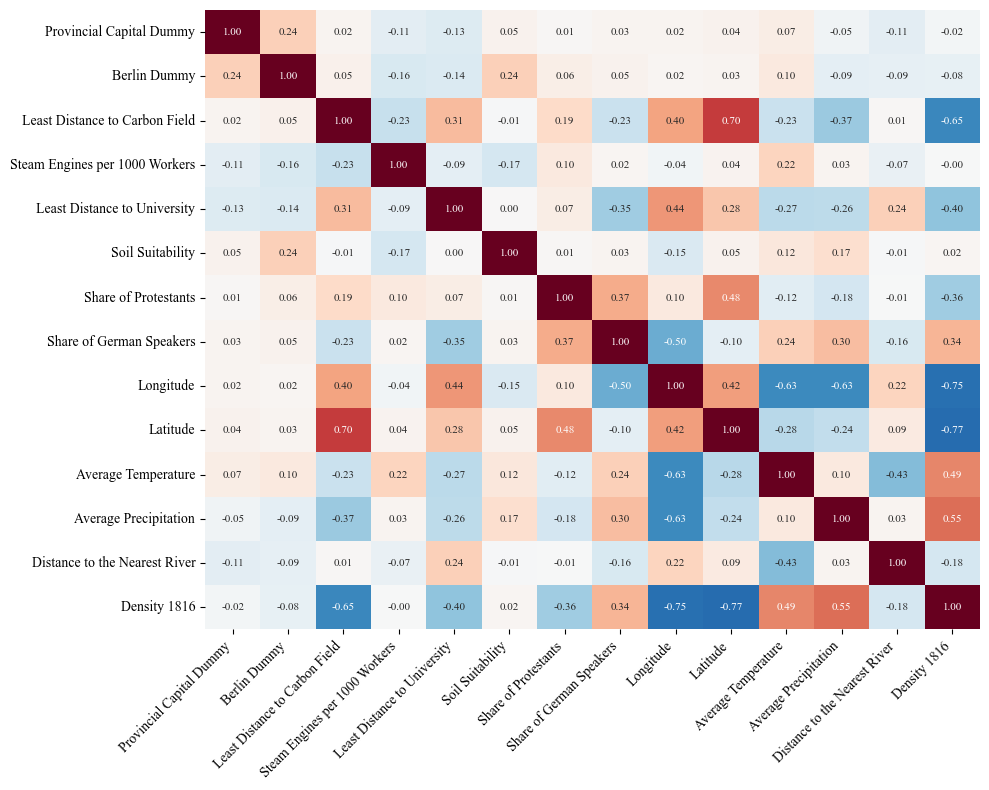

In [144]:
list_cont = [
    "Least Distance to Carbon Field",
    "Steam Engines per 1000 Workers",
    "Least Distance to University",
    "Soil Suitability",
    "Share of Protestants",
    "Share of German Speakers",
    "Longitude",
    "Latitude",
    "Average Temperature",
    "Average Precipitation",
    "Distance to the Nearest River",
    "Density 1816"
]

list_dummy = [
    "Provincial Capital Dummy",
    "Berlin Dummy"
]

create_heatmap(multicoll, list_cont, list_dummy)


## VIF

In [145]:
multicoll.columns

Index(['Least Distance to Carbon Field', 's_industry', 'Share of Protestants',
       'Share of German Speakers', 'Longitude', 'Latitude', 'Soil Suitability',
       'Average Temperature', 'Average Precipitation',
       'Distance to the Nearest River', 'uni_dummy',
       'Least Distance to University', 'Provincial Capital Dummy',
       'Berlin Dummy', 'Density 1816', 'Steam Engines per 1000 Workers',
       'per_low', 'per_medium', 'per_unskilled', 'per_high', 'd_Hauptberuf',
       'horsepower', 'randomness', 'Constant'],
      dtype='object')

In [146]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

var_list = [
    "Least Distance to Carbon Field",
    "Steam Engines per 1000 Workers",
    "Least Distance to University",
    "Soil Suitability",
    "Share of Protestants",
    "Share of German Speakers",
    "Longitude",
    "Latitude",
    "Average Temperature",
    "Average Precipitation",
    "Distance to the Nearest River",
    "Density 1816",
    "Provincial Capital Dummy",
    "Berlin Dummy",
    "Constant"
]

X = multicoll[var_list]

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data


,Variable,VIF
0,Least Distance to Carbon Field,2.849101
1,Steam Engines per 1000 Workers,1.492349
2,Least Distance to University,1.473797
3,Soil Suitability,1.211486
4,Share of Protestants,2.031141
5,Share of German Speakers,1.917486
6,Longitude,5.661600
7,Latitude,4.586926
8,Average Temperature,3.282265
9,Average Precipitation,2.995058


# EDA

In [147]:
def change(old_X_log, new_X_log, old_y_log, coef):
    
    old_X = np.exp(old_X_log)
    new_X = np.exp(new_X_log)
    old_y = np.exp(old_y_log)
    
    percent_change_X = (new_X - old_X) / old_X * 100
    
    percent_change_y = percent_change_X * coef
    
    new_y = old_y*(1+(percent_change_y/100))
    
    return print(f"change in y: {percent_change_y:2f} %. new y:{new_y:2f}. old y:{old_y:2f}")

change(1, 1.1, 10, 1)

change in y: 10.517092 %. new y:24343.009424. old y:22026.465795


In [148]:
median_un = merged_df["per_unskilled"].median()
median_county = merged_df[merged_df["per_unskilled"] == median_un]
median_un

-0.6369777124688629

In [149]:
median_county

,id_inequality,rb_id,rb_name_x,province_id,s_industry,s_prot,s_german,longitud,latitud,slope_km,soil_suitability,mean_temp,mean_preci,dist_100km,log_distance_carbon_c,NAME,county_name,uni_dummy,min_distance_uni,prov_cap_dummy,BER_dummy,density,d_Hauptberuf,high,medium,low,unskilled,Industriearbeiter,Anteil_Industriearbeiter,per_high,per_medium,per_low,per_unskilled,steamengines_number,horsepower,rb_name_y
326,397.0,30.0,Schleswig,8.0,23.693008,97.888989,99.299674,10.608754,53.590075,0.044,2.666667,8.583,60.008,0.078,4.930541,LAUENBURG,Lauenburg Holstein,0,0.878965,0,0,38.114508,24751.0,213.601539,7172.58273,4274.297359,13090.518372,6662.0,0.269161,-4.752509,-1.2386,-1.756246,-0.636978,2.488228,5.632293,Schleswig


In [150]:
Lauenburg_steam = median_county["steamengines_number"]
print(Lauenburg_steam)

326    2.488228
Name: steamengines_number, dtype: float64


In [151]:
median_un = median_county["per_unskilled"]
median_un

326   -0.636978
Name: per_unskilled, dtype: float64

In [152]:
quantile_steam = merged_df["steamengines_number"].quantile(0.75)
Lauenburg_steam = median_county["steamengines_number"]
#median_un = median_county["per_unskilled"]
median_steam = merged_df["steamengines_number"].median()
mean_steam = merged_df["steamengines_number"].mean()
change(2.488228, quantile_steam, -0.636978, -0.203)

change in y: -6.352300 %. new y:0.495292. old y:0.528888


In [153]:
quantile_steam = merged_df["steamengines_number"].quantile(0.75)
Lauenburg_steam = median_county["steamengines_number"]
median_steam = merged_df["steamengines_number"].median()
mean_steam = merged_df["steamengines_number"].mean()

quantile_steam = np.exp(quantile_steam)
median_steam = np.exp(median_steam)
mean_steam = np.exp(mean_steam)
print(quantile_steam)
print(median_steam)
print(mean_steam)
print(f"Lauenburg steams: {np.exp(median_county['steamengines_number'])}")
print(f"Lauenburg per un: {np.exp(median_county['per_unskilled'])}")
print(f"Lauenburg per un: {median_county['unskilled']}")

15.80746916345479
11.25495863956456
10.948161341606077
Lauenburg steams: 326    12.039918
Name: steamengines_number, dtype: float64
Lauenburg per un: 326    0.528888
Name: per_unskilled, dtype: float64
Lauenburg per un: 326    13090.518372
Name: unskilled, dtype: float64
